# Week 8 - Support Vector Machines
### Dr. David Elliott

1.6. [Support Vector Classifier (SVC)](#svc)

1.7. [Support Vector Machine (SVM)](#svm)

1.8. [Exercises](#exercises)

In [1]:
%matplotlib inline

import os # locating directories

import numpy as np   # Arrays
import pandas as pd  # DataFrames

# Plotting
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['animation.embed_limit'] = 30000000.0
plt.rcParams['figure.dpi'] = 300
import seaborn as sns; sns.set()

from sklearn.datasets import load_iris           # for the Iris data
from IPython.display import Image                # displaying .png images
from sklearn.svm import SVC, LinearSVC           # SVM
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
from sklearn.datasets import make_classification, make_moons  # make example data

# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
image_dir = os.path.join(os.getcwd(),"Images")

# displays the graph in the middle of the notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
iris = load_iris(as_frame=True)  # data stored in a `sklearn.utils.Bunch`
iris_df = iris['data']           # get features DataFrame
target = iris['target']          # get target Series
# get the labels of flowers capitalised for visualisation
target_names = list(map(lambda s: s.capitalize(), iris['target_names']))

# create a dictionary with the original labels decoded (inverse of LabelEncoder)
decode_label = dict(zip(range(3), target_names))

# make a label encoder to use later if needed
le = LabelEncoder().fit(target_names)
# add the target labels to df for visualisation purposes
iris_vis = pd.concat([iris_df, target],axis=1)
# turn the ints to labels
iris_vis["target"] = iris_vis["target"].replace(decode_label)
# Capitalize column names for plotting
iris_vis.columns = [x.capitalize() for x in list(iris_vis.columns)]
# reduce the data for example
X_AX_LABEL = "Petal length (cm)"
Y_AX_LABEL = "Petal width (cm)"
REMOVE = "Virginica"

iris_reduced = iris_vis[[X_AX_LABEL, Y_AX_LABEL, "Target"]]
iris_reduced = iris_reduced[iris_reduced.Target != REMOVE]

We can't always perfectly separate the data with a $K − 1$ dimensional hyperplane. To overcome this problem we could either:
- tweak the constraints on the hyperplane to allow some points to be misclassified (soft margin),
- transform the data to be separable by a hyperplane in another space (kernel method).

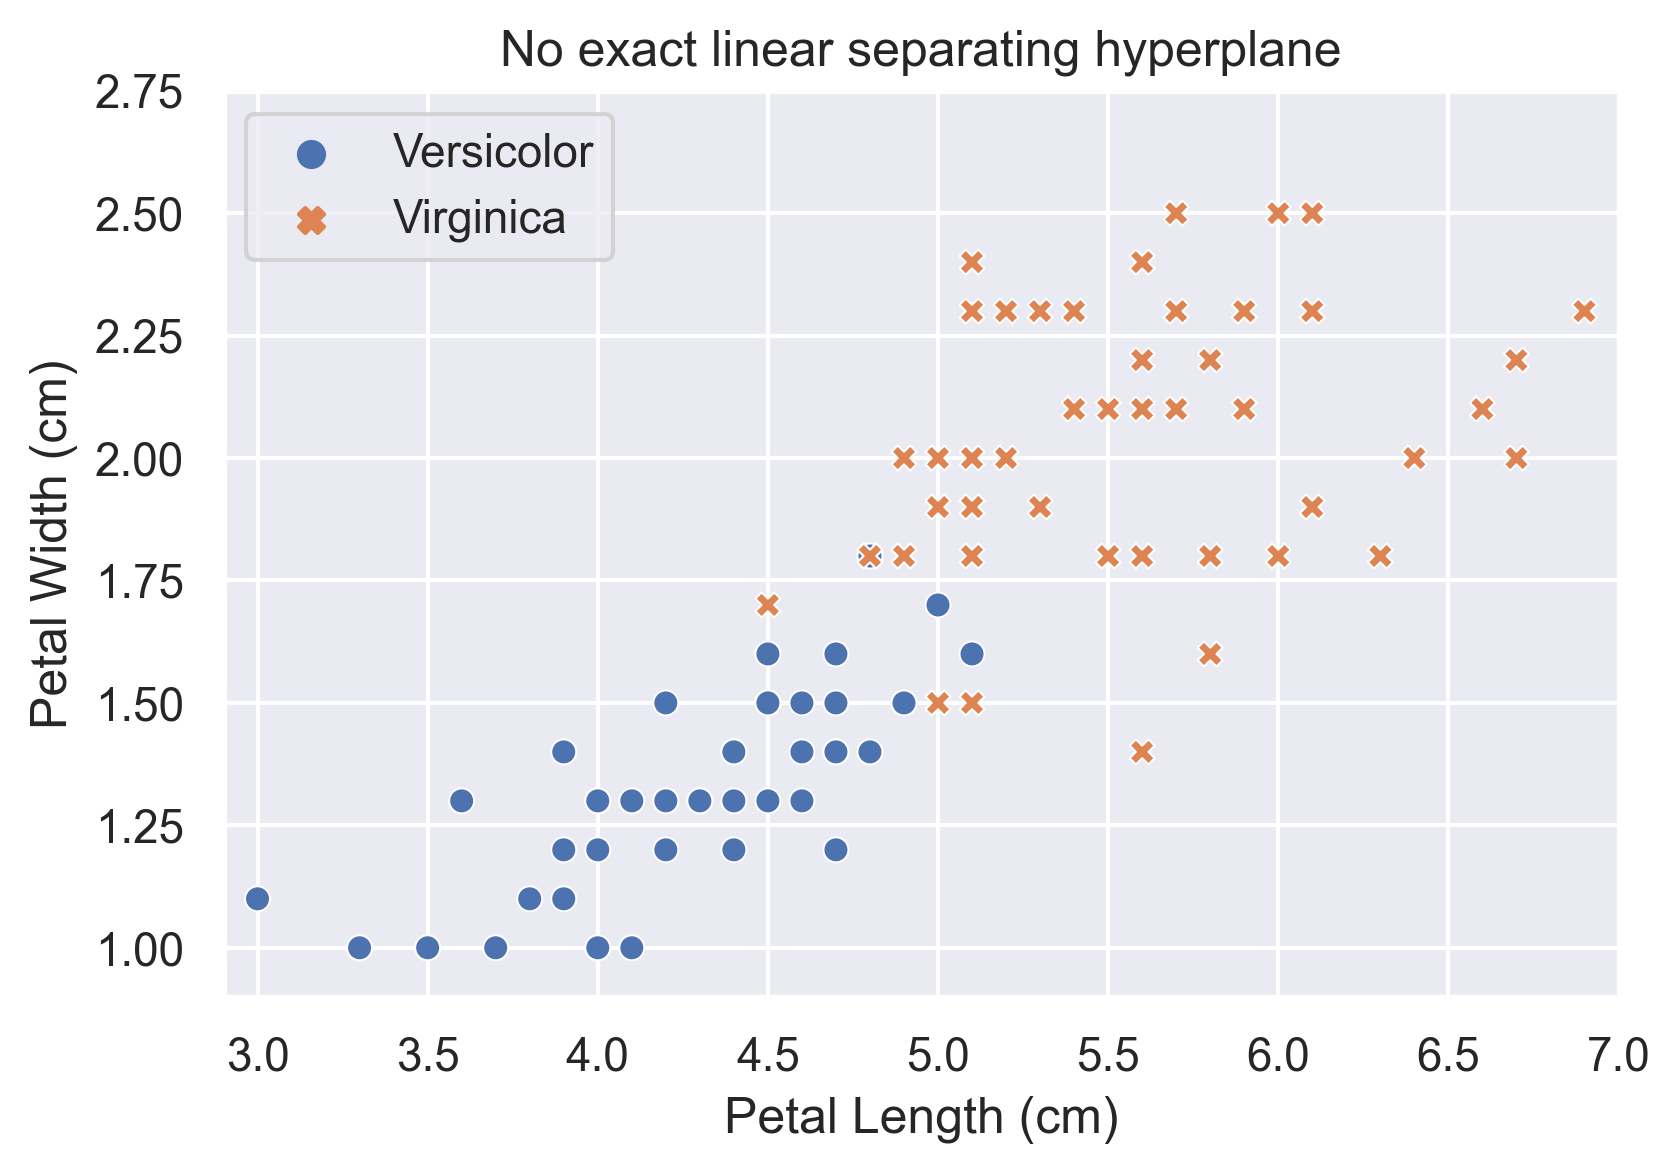

In [3]:
def svc_decision_boundary(clf, xmin=0, xmax=5.5, highlight=True, axes_limit = [0, 5.5, 0, 2]):
    w = clf.coef_[0]
    b = clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = clf.support_vectors_
    if highlight:
        g = sns.scatterplot(x = svs[:, 0], y = svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "g-", linewidth=2)
    plt.plot(x0, gutter_up, "r--", linewidth=2)
    plt.plot(x0, gutter_down, "r--", linewidth=2)
    
    plt.axis(axes_limit)


def soft_margin(title, hyperplane=False):
    virgin_versi = iris_vis[["Petal length (cm)", "Petal width (cm)", "Target"]]
    virgin_versi = virgin_versi[virgin_versi.Target != "Setosa"]

    X = virgin_versi[["Petal length (cm)", "Petal width (cm)"]].values
    y = virgin_versi[["Target"]].replace({'Versicolor':0, 'Virginica':1}).values.ravel()
    
    if hyperplane:
        svm_clf = SVC(kernel="linear", C=100)
        svm_clf.fit(X, y)

        svc_decision_boundary(svm_clf, 2.9, 7)
    labels = virgin_versi[["Target"]].values.ravel()
    sns.scatterplot(x = X[:,0], y = X[:,1], hue=labels, style = labels)
    plt.axis([2.9, 7, 0.9, 2.75])
    plt.title(title)
    plt.xlabel("Petal Length (cm)")
    plt.ylabel("Petal Width (cm)")
    
soft_margin("No exact linear separating hyperplane")
plt.show()

# 1.6. Support Vector Classifier (SVC) <a id='svc'></a>

SVC's are a generalisation and extension of the maximal margin classifier so it can be applied to a broader range of cases<sup>1</sup>.

In practice they are more robust to individual observations and better classify most training observations than the Maximal Margin Classifier. This is because they take the approach it is better to missclassify some training examples in order to do a better job classifying the rest.

This is called a *soft margin* as it allows some violations by the training data by a small subset of training observation, not only on the wrong side of the margin, but wrong side of the hyperplane.

__Notes__
- "Developed in the computer science community in the 1990s"<sup>2</sup>

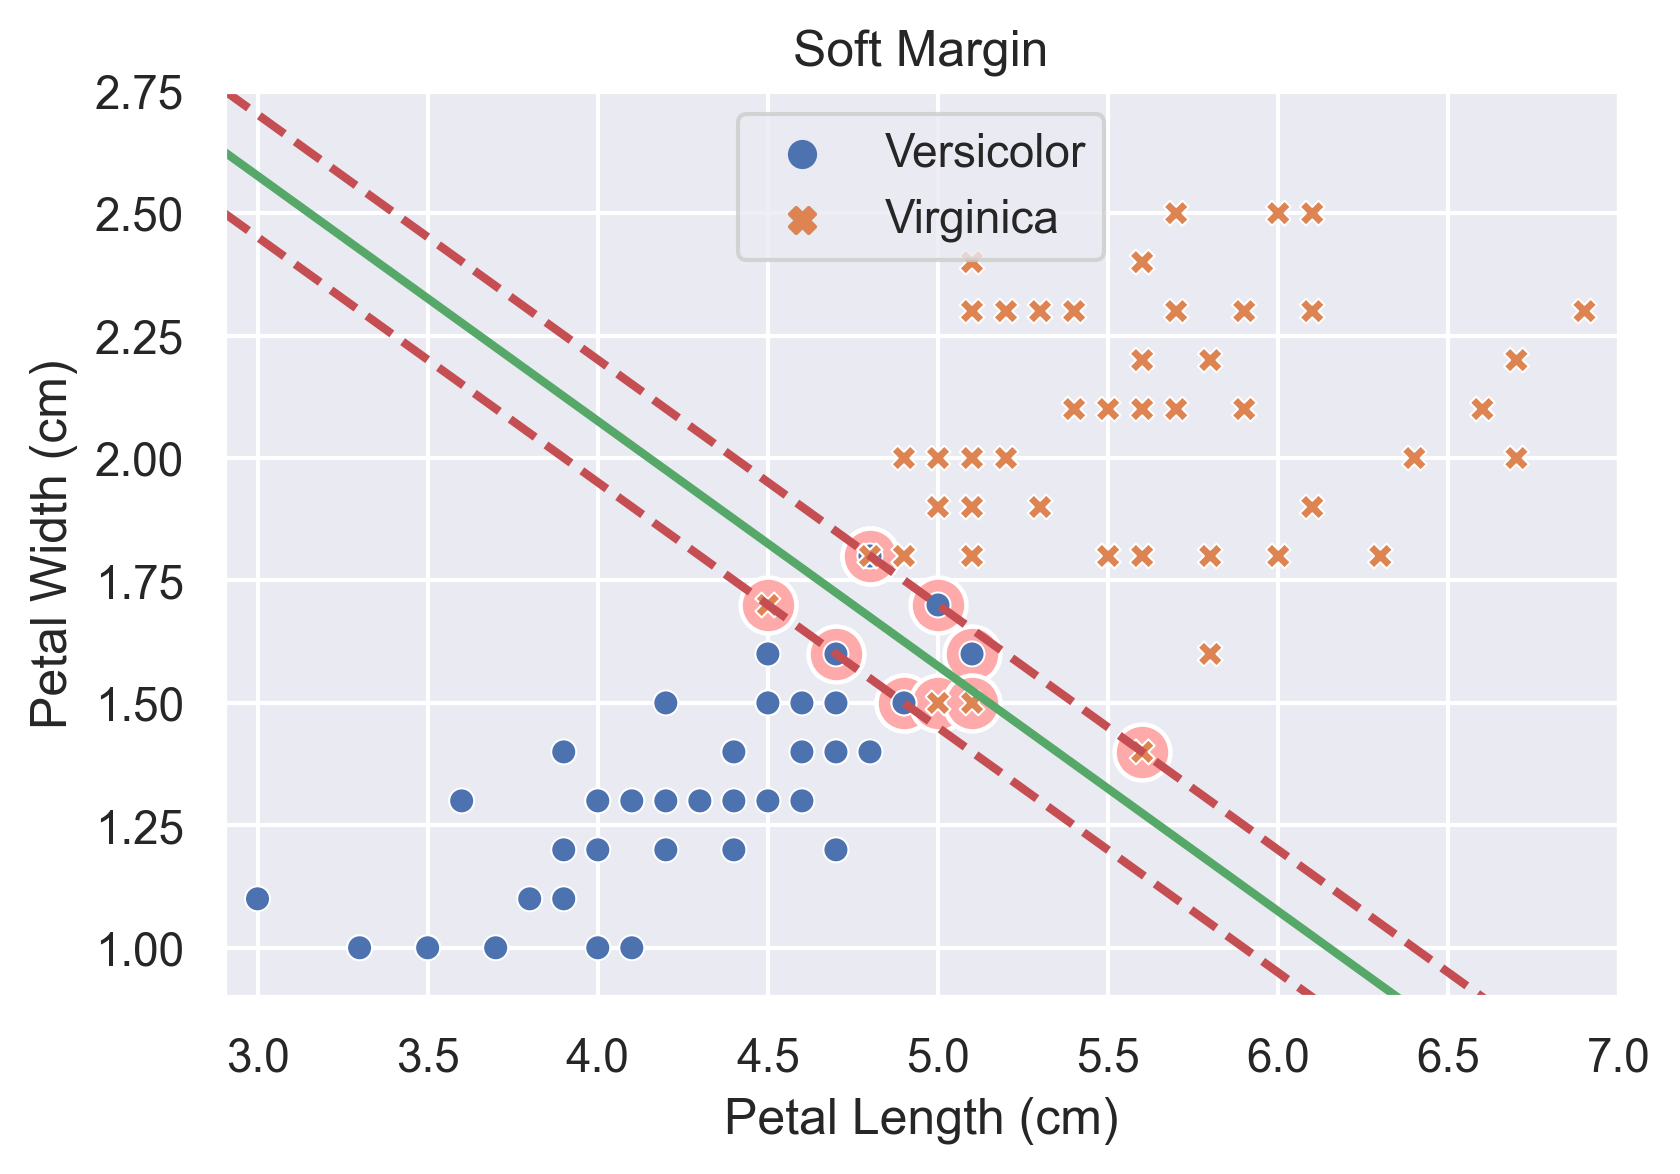

In [4]:
soft_margin("Soft Margin", hyperplane=True)
plt.show()

We want to relax the constraints

$\mathbf{x}_i \cdot \mathbf{w} + b \geq +1 \quad \text{for} \ y_i = +1$,

$\mathbf{x}_i \cdot \mathbf{w} + b \leq -1 \quad \text{for} \ y_i = -1$,

when necessary.

This can be done firstly by introducing positive slack variables $\xi_i, i = 1, \ldots , l$ in the constraints<sup>5</sup>, which then become<sup>6</sup>:

$\mathbf{x}_i \cdot \mathbf{w} + b \geq +1 - \xi_i \quad \text{for} \ y_i = +1$,

$\mathbf{x}_i \cdot \mathbf{w} + b \leq -1 + \xi_i \quad \text{for} \ y_i = -1$,

$\xi_i \geq 0 \quad \forall_i$.

__Notes__
- $\sum_i\xi_i$ is an upper bound on the number of training errors
- $\xi_i$ tells us where the $i$th observation is located relative to the hyperplane; $\xi_i = 0$ being on the correct side of the margin, $\xi_i > 0$ being on the wrong side of the margin, and $\xi_i > 1$ on the wrong side of the hyperplane.
- $\xi_1 = ... = \xi_n = 0$ is the maximal margin hyperplane optimisation.
- slack variable $\xi_1,..., \xi_n$ allow individual observations to be on the wrong side of the margin or hyperplane.
- test observations are classified as before, $f(x^*) = \beta_0 + \beta_1x^*_1 + ... + \beta_px^*_p$

## Tuning Parameter (C)

To ensure there is a penelty, $C$, for relaxing the constraint, we can change our objective function to be minimised from $\frac{||\mathbf{w}||^2}{2}$ to,

$\frac{||\mathbf{w}||^2}{2}+C(\sum_i\xi_i)^k$.

If we set $k=1$ neither the $\xi_i$ or their Lagrange multipliers appear in the Wolfe dual problem. This means we now have<sup>6</sup>:

$L_D \equiv \sum_i\alpha_i - \frac{1}{2}\sum_{i,j}\alpha_i\alpha_jy_iy_j\mathbf{x}_i\cdot \mathbf{x}_j \quad \text{s.t.} \quad 0 \leq \alpha_i \leq C, \quad \sum_i\alpha_iy_i = 0$.

This also has the same solution as before:

$w = \sum^{N_S}_{i=1}\alpha_iy_i\mathbf{x}_i$.

- the $\alpha_i$ now have an upper bound of $C$.

- In `Sci-kit learn` _"the strength of the regularization is inversely proportional to C"_

In [5]:
def soft_margin(c_list):
    virgin_versi = iris_vis[["Petal length (cm)", "Petal width (cm)", "Target"]]
    virgin_versi = virgin_versi[virgin_versi.Target != "Setosa"]

    X = virgin_versi[["Petal length (cm)", "Petal width (cm)"]].values
    y = virgin_versi[["Target"]].replace({'Versicolor':0, 'Virginica':1}).values.ravel()

    scaler = StandardScaler()
    svm_clf1 = LinearSVC(C=c_list[0], loss="hinge", random_state=42)
    svm_clf2 = LinearSVC(C=c_list[1], loss="hinge", random_state=42)

    scaled_svm_clf1 = Pipeline([
            ("scaler", scaler),
            ("linear_svc", svm_clf1),
        ])
    scaled_svm_clf2 = Pipeline([
            ("scaler", scaler),
            ("linear_svc", svm_clf2),
        ])

    scaled_svm_clf1.fit(X, y)
    scaled_svm_clf2.fit(X, y)

    # Convert to unscaled parameters
    b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
    b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
    w1 = svm_clf1.coef_[0] / scaler.scale_
    w2 = svm_clf2.coef_[0] / scaler.scale_
    svm_clf1.intercept_ = np.array([b1])
    svm_clf2.intercept_ = np.array([b2])
    svm_clf1.coef_ = np.array([w1])
    svm_clf2.coef_ = np.array([w2])

    # Find support vectors (LinearSVC does not do this automatically)
    t = y * 2 - 1
    support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
    support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
    svm_clf1.support_vectors_ = X[support_vectors_idx1]
    svm_clf2.support_vectors_ = X[support_vectors_idx2]

    fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

    plt.sca(axes[0])
    svc_decision_boundary(svm_clf1, 3, 7)
    legend_labels = virgin_versi[["Target"]].values.ravel()
    sns.scatterplot(x = X[:,0], y = X[:,1], hue=legend_labels, style = legend_labels)
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    plt.legend(loc="upper left", fontsize=14)
    plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
    plt.axis([2.9, 7, 0.9, 2.75])

    plt.sca(axes[1])
    svc_decision_boundary(svm_clf2, 3, 7)
    g = sns.scatterplot(x = X[:,0], y = X[:,1], hue=legend_labels, style = legend_labels, legend=False)
    plt.xlabel("Petal length", fontsize=14)
    plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
    plt.axis([2.9, 7, 0.9, 2.75])

    plt.show()

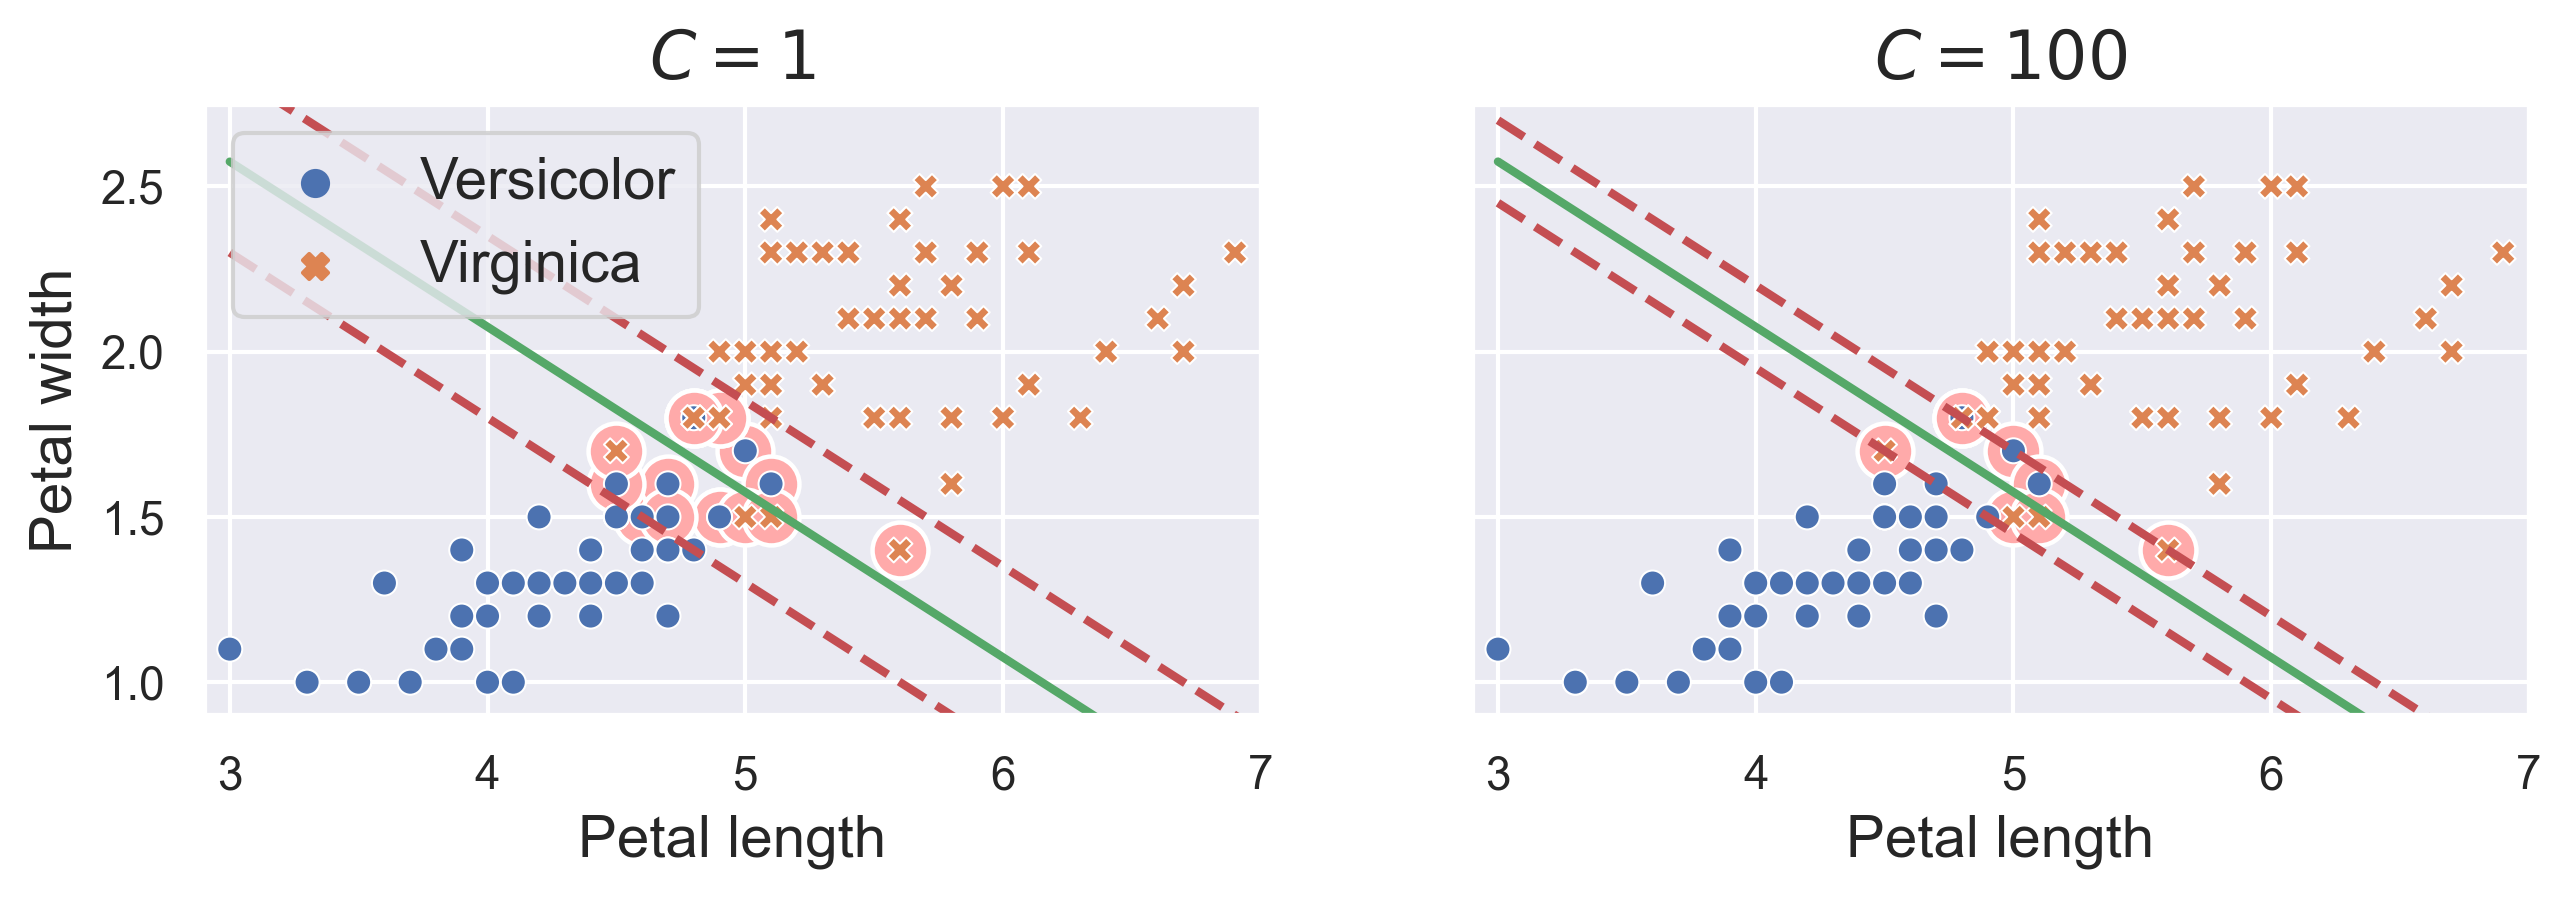

In [6]:
soft_margin([1,100])

$C$ is a tuning parameter that controls the bias-variance trade-off. 

When $C$ is small we have narrow margins rarely violated, but highly fit to the training data (low bias-high variance). Coversely, when larger, the margin is wider amounting to less hard fitting (high bias-low variance).

Like most hyper-parameters, it is often chosen using cross-validation.

Alike to maximal margin classifiers, SVC's only rely on a few observations, those on the margin or those that violate the margin (*Support Vectors*) - if they are on the correct side of the margin they dont change the classifier. This does mean that they are robust to observations far away from the hyperplane.

__TODO__
- refs for above

- [Insert a line about the bias-variance trade-off]

It is common to define $C$ as $C = \frac{1}{\nu N}$, where $0 < \nu \leq 1$ controls the fraction of misclasified points during the training phase <sup>7</sup>. 

# 1.7. Support Vector Machine <a id='svm'></a>
Aims to address the situation where the boundry between two classes is not linear.

In [7]:
from sklearn.preprocessing import PolynomialFeatures

def non_linear_examples():
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 5))
    axes = axes.flatten()
    plt.sca(axes[0])
    nl1, y1 = make_classification(n_samples=300, n_features=2, 
                                          n_redundant=0, n_informative= 2, 
                                          n_classes=3, n_clusters_per_class=1, 
                                          random_state=14, class_sep=30, 
                                          hypercube=False)
    y1 = np.where(y1==1,0,y1)
    y1 = np.where(y1==2,1,y1)
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)
    plt.axis([-5, 5.5, -8, 8])

    plt.sca(axes[1])
    nl2, y2 = make_moons(n_samples=300, noise=0.15, random_state=42)
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)
    
    svm_clf1 = LinearSVC(random_state=42).fit(nl1, y1)
    svm_clf2 = LinearSVC(random_state=42).fit(nl2, y2)

    # Convert to unscaled parameters
    b1 = svm_clf1.intercept_[0]
    b2 = svm_clf2.intercept_[0]
    w1 = svm_clf1.coef_[0]
    w2 = svm_clf2.coef_[0]

    # Find support vectors (LinearSVC does not do this automatically)
    t1 = y1 * 2 - 1
    t2 = y2 * 2 - 1
    support_vectors_idx1 = (t1 * (nl1.dot(w1) + b1) < 1).ravel()
    support_vectors_idx2 = (t2 * (nl2.dot(w2) + b2) < 1).ravel()
    svm_clf1.support_vectors_ = nl1[support_vectors_idx1]
    svm_clf2.support_vectors_ = nl2[support_vectors_idx2]

    plt.sca(axes[2])
    svc_decision_boundary(svm_clf1, -5, 4, highlight=False, axes_limit = [-5, 5.5, -8, 8])
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)

    plt.sca(axes[3])
    svc_decision_boundary(svm_clf2, -1.5, 2.5, highlight=False, axes_limit = [-1.5, 2.5, -1, 1.5])
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)

    plt.show()

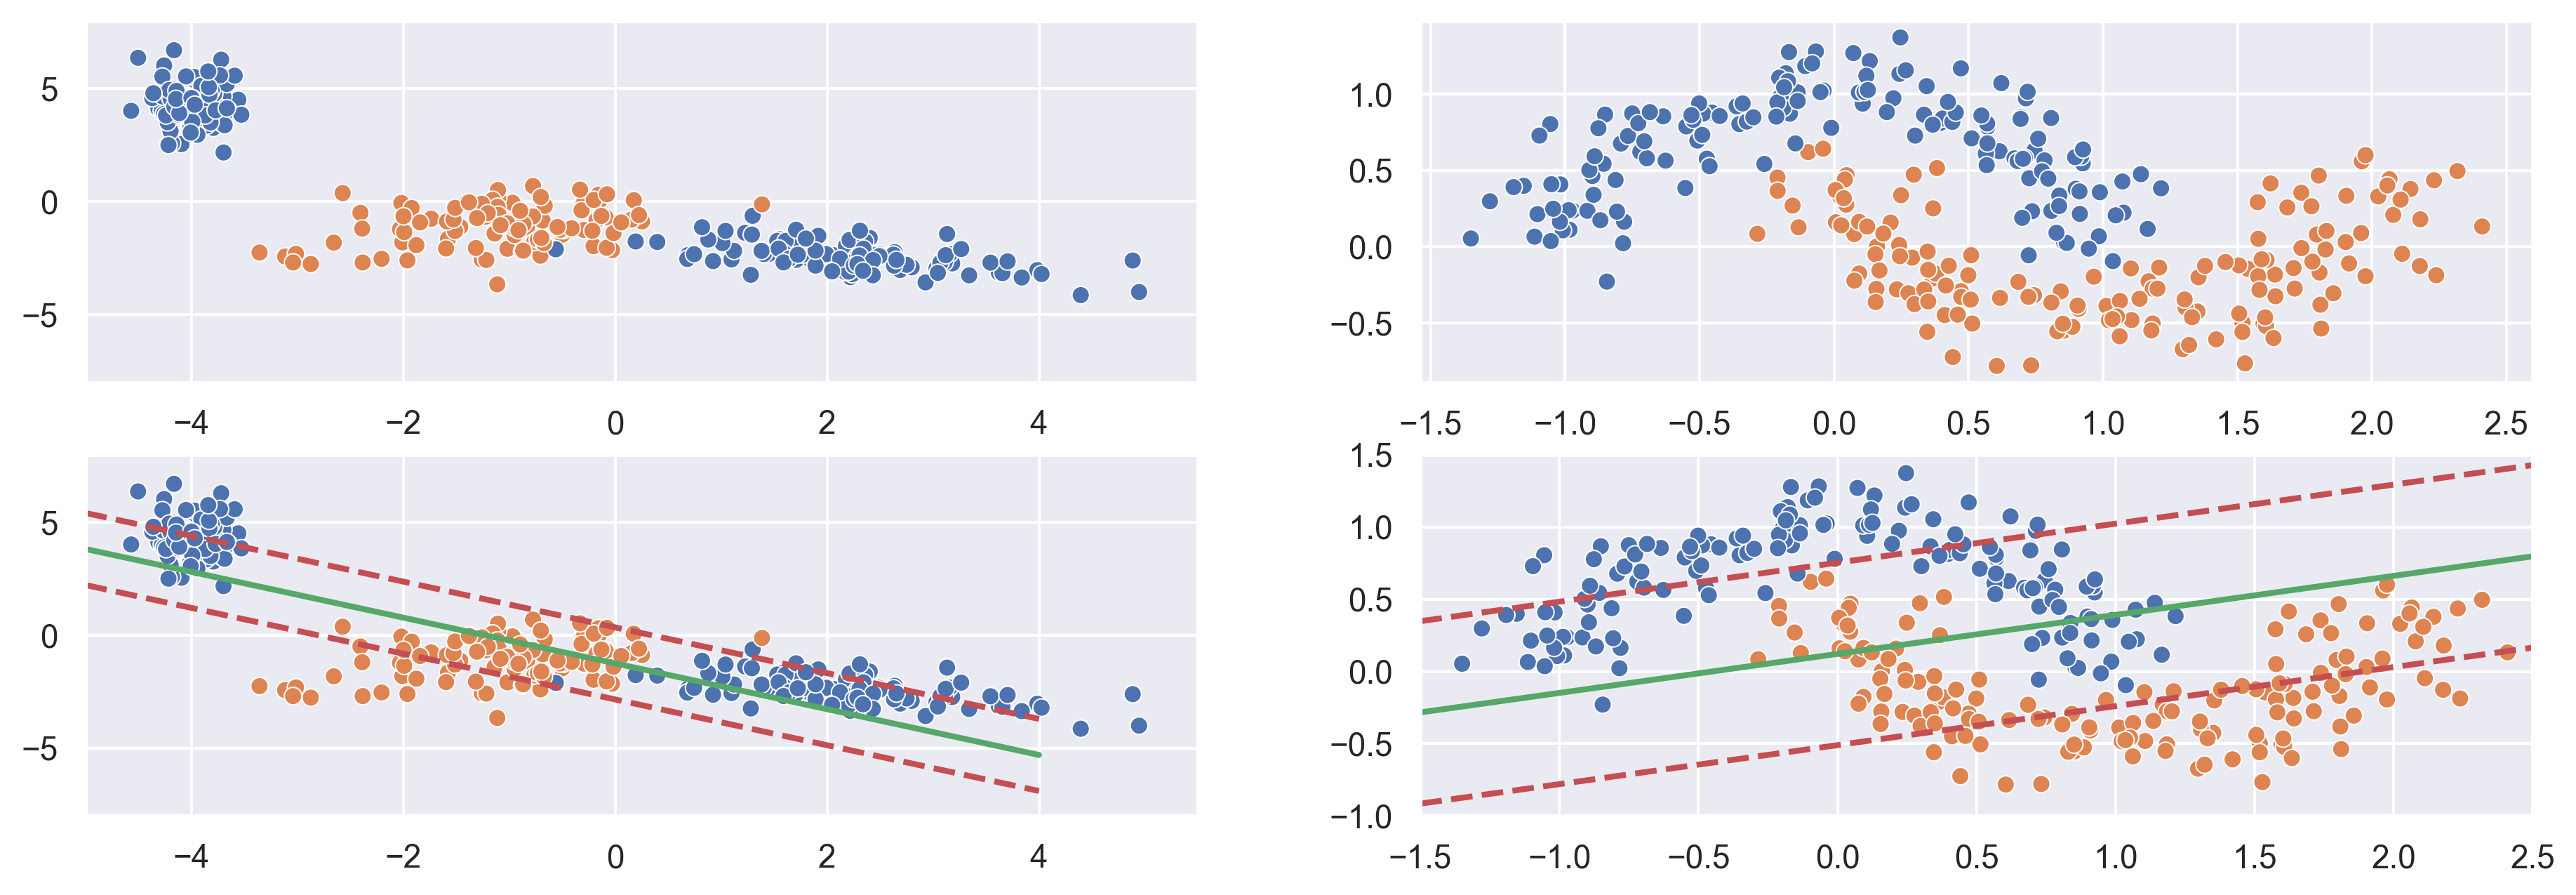

In [8]:
import warnings
# TEMP
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    non_linear_examples()

## Feature Engineering

We could consider enlarging the feature space using quadratic, cubic or higher-order polynomial functions. This would allow us to project our data onto a higher-dimensional space via a mapping function $\phi$ where they are linearly separable (using a linear SVM model in this new feature space). For example:

$\phi(\mathbf{x}_1, \mathbf{x}_2) = (\mathbf{z}_1,\mathbf{z}_2,\mathbf{z}_3) = (\mathbf{x}_1,\mathbf{x}_2,\mathbf{x}^2_1+\mathbf{x}^2_2)$

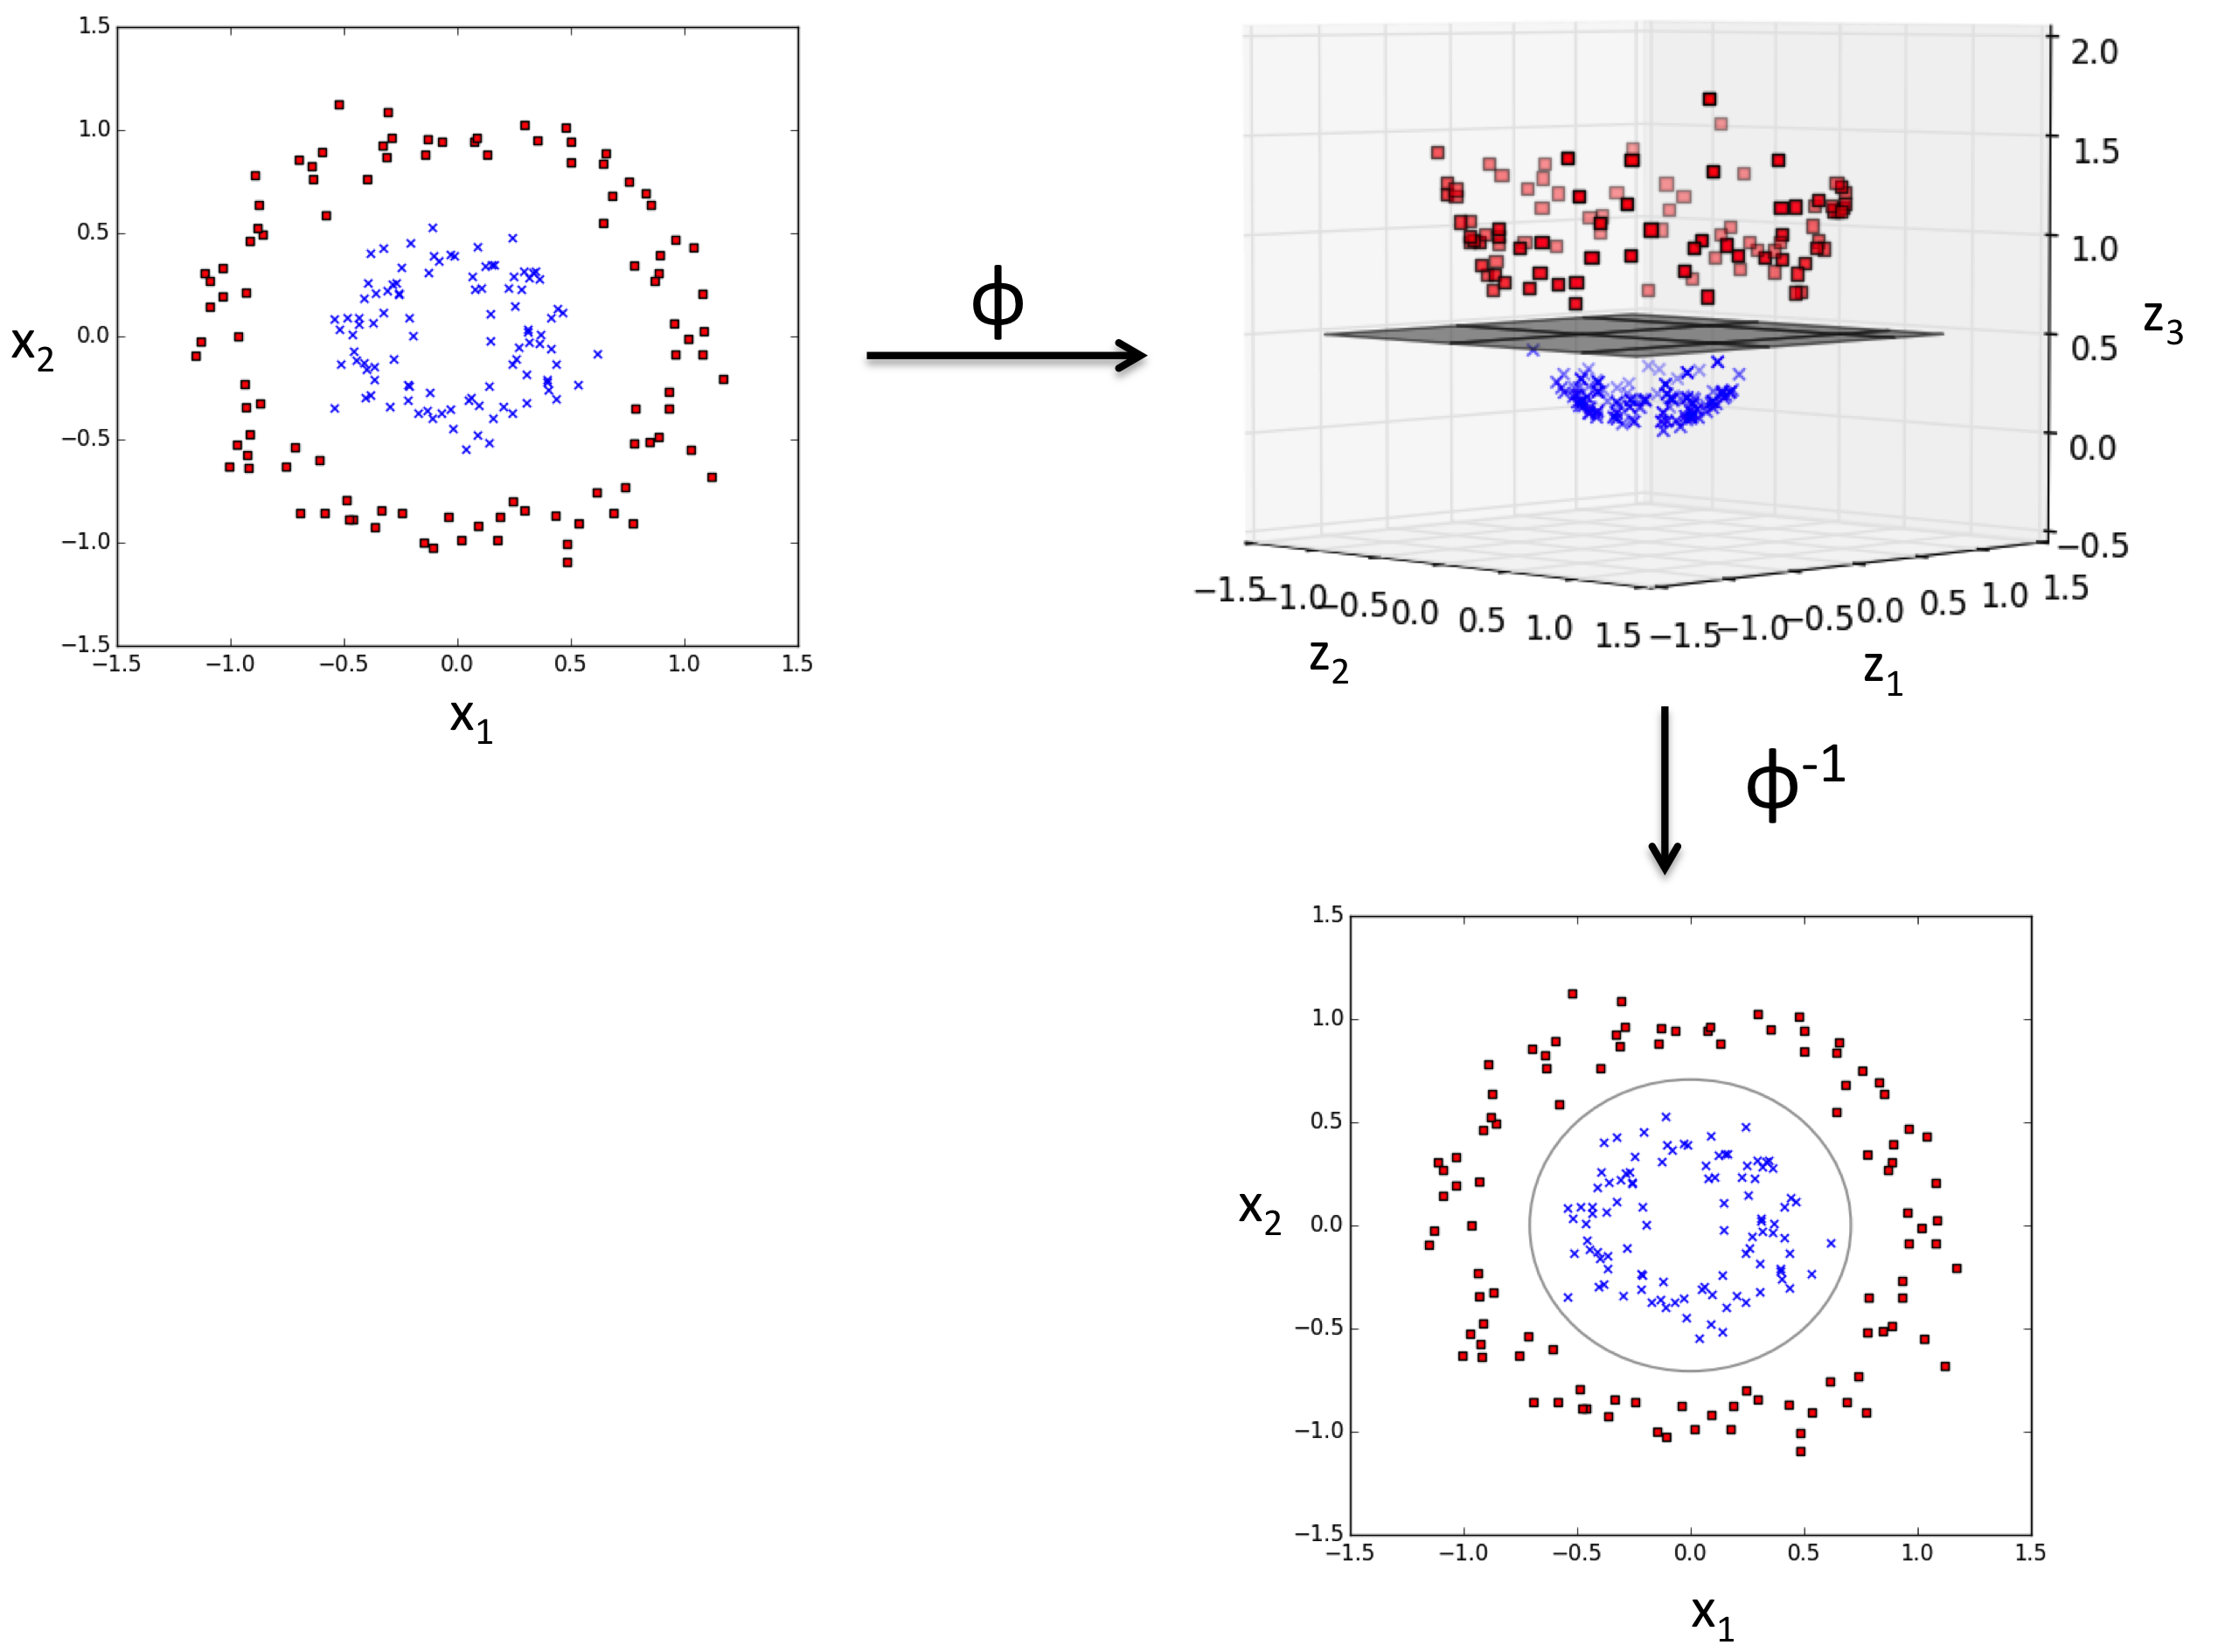

In [25]:
# TODO - if time code something like this up

# Image from https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch03/ch03.ipynb
Image(filename='Images/03_13.png', width=700)

__Extra__

As an additional example we can see below that our $x_1$ is not linearly separable but it is when we add in our second feature $x_2 = (x_1)^2$

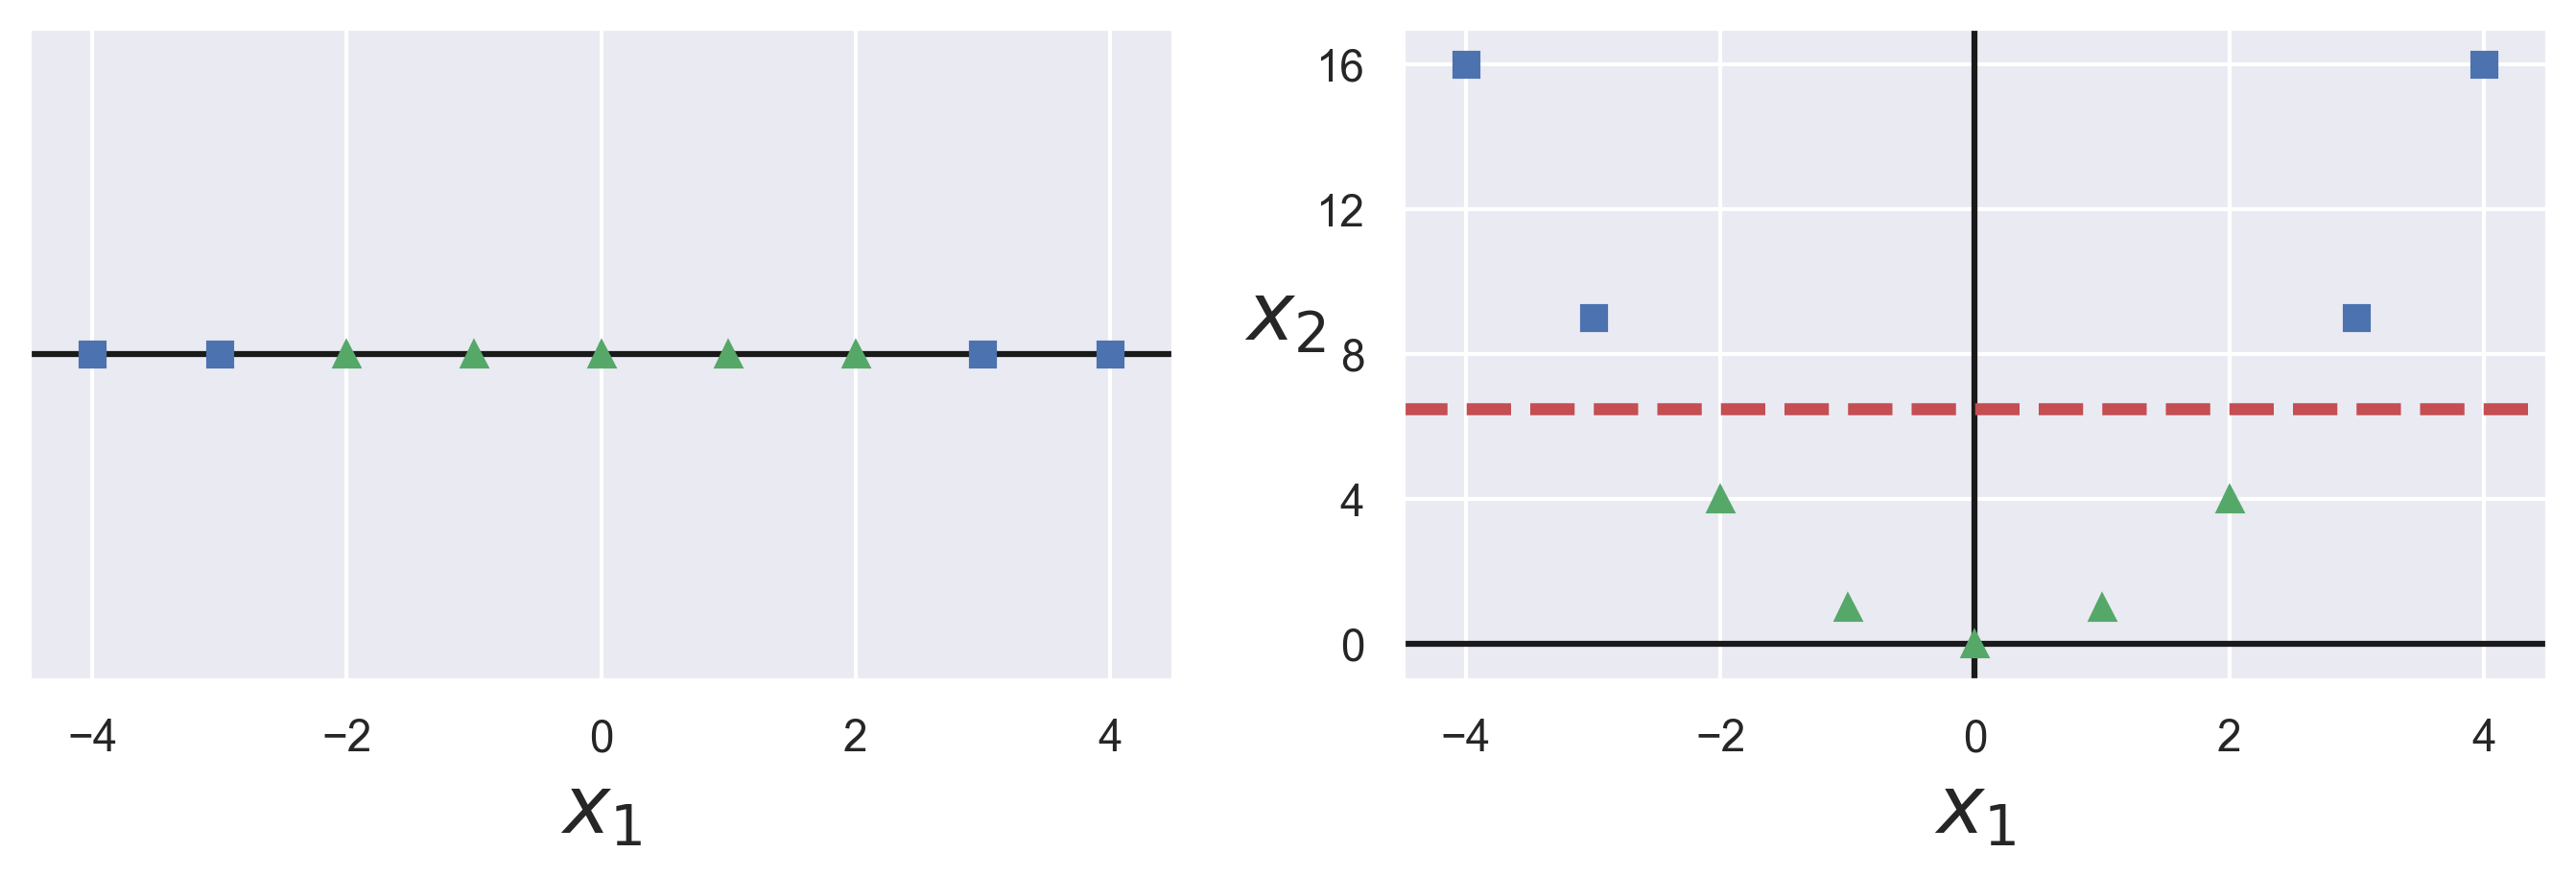

In [26]:
# https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def poly_info():
    X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
    X2D = np.c_[X1D, X1D**2]
    y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    plt.figure(figsize=(10, 3))

    plt.subplot(121)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
    plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
    plt.gca().get_yaxis().set_ticks([])
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.axis([-4.5, 4.5, -0.2, 0.2])

    plt.subplot(122)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
    plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
    plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
    plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
    plt.axis([-4.5, 4.5, -1, 17])

    plt.subplots_adjust(right=1)

    plt.show()
    
poly_info()

### Gaussian Radial Basis Function

We could instead use a Gaussian Radial Basis Function (RBF),

$\phi_\gamma(X,\ell) = \exp(-\gamma||X-\ell||^2)$.

This is a bell-shaped function which measures how muchy an instanse resembles a _landmark_, with the function varying from 0 (far away) to 1 (at the landmark).

In the example below we set our landmarks to $x_1$ = -2 and $x_1 = 1$. 

---
Hands on machine learning

__TODO__
- Tidy the code below (I just copied and pasted bits because I'm lazy)

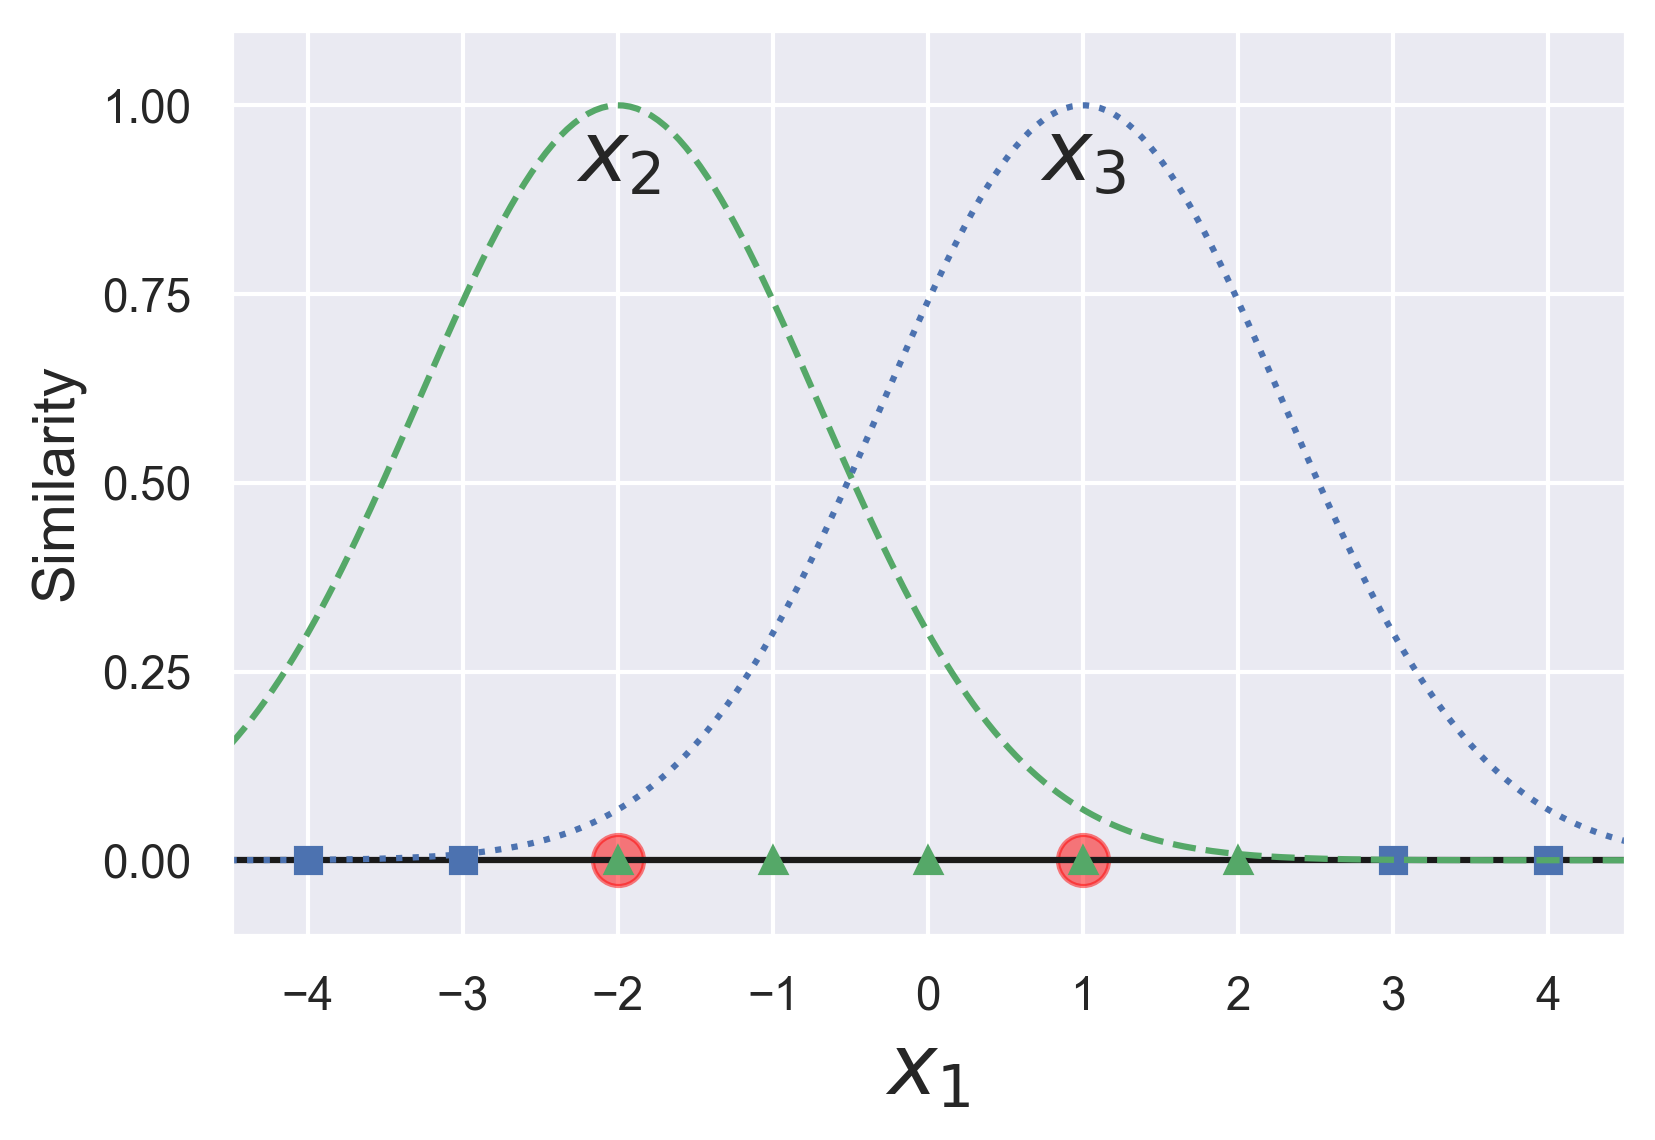

In [32]:
# copied from https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def gaussian_rbf(x, landmark, gamma):
        return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

def rbk_info():

    gamma = 0.3
    X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
    X2D = np.c_[X1D, X1D**2]
    y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
    x2s = gaussian_rbf(x1s, -2, gamma)
    x3s = gaussian_rbf(x1s, 1, gamma)

    XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
    yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    #plt.figure(figsize=(10.5, 4))

    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
    plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
    plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
    plt.plot(x1s, x2s, "g--")
    plt.plot(x1s, x3s, "b:")
    plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"Similarity", fontsize=14)
    plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
    plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
    plt.axis([-4.5, 4.5, -0.1, 1.1])
    
rbk_info()

Using the example of $x_1=-1$ we can see it is a distance of 1 from the first landmark and 2 from the second.

If we set $\gamma = 0.3$ then our new features are:

$x_2 = \exp(-0.3 \times 1^2) \approx 0.74$

$x_3 = \exp(-0.3 \times 2^2) \approx 0.30$

In order to fiund the landmarks the simplist approach is just to create a landmark at each instance in the dataset.

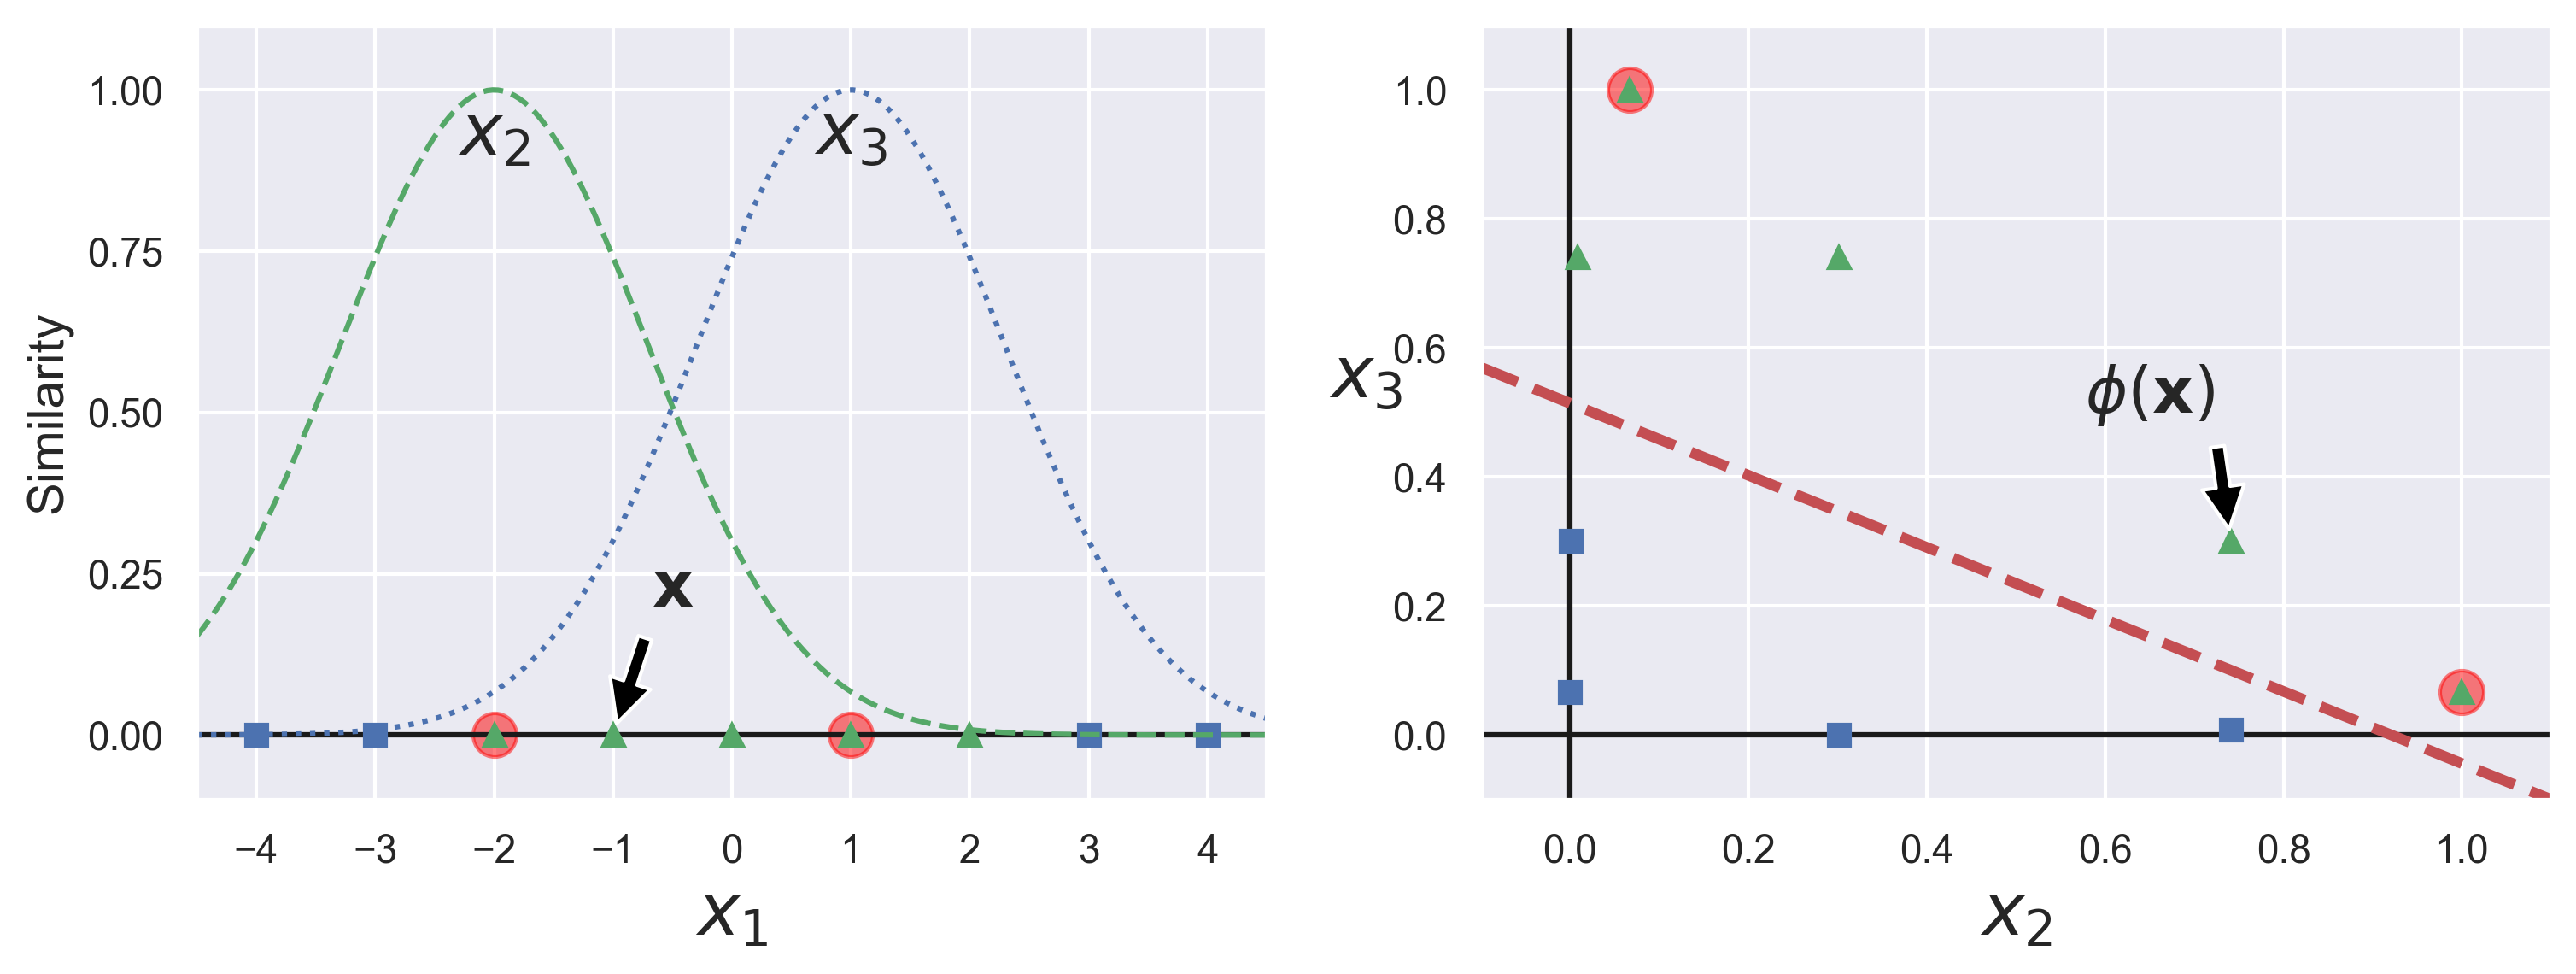

In [43]:
import math

# copied from https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def gaussian_rbf(x, landmark, gamma):
        return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

def rbk_info():

    gamma = 0.3
    X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
    X2D = np.c_[X1D, X1D**2]
    y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
    x2s = gaussian_rbf(x1s, -2, gamma)
    x3s = gaussian_rbf(x1s, 1, gamma)

    XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
    yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    plt.figure(figsize=(10.5, 4))

    plt.subplot(121)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
    plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
    plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
    plt.plot(x1s, x2s, "g--")
    plt.plot(x1s, x3s, "b:")
    plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"Similarity", fontsize=14)
    plt.annotate(r'$\mathbf{x}$',
                 xy=(X1D[3, 0], 0),
                 xytext=(-0.5, 0.20),
                 ha="center",
                 arrowprops=dict(facecolor='black', shrink=0.1),
                 fontsize=18,
                )
    plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
    plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
    plt.axis([-4.5, 4.5, -0.1, 1.1])

    plt.subplot(122)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
    plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
    plt.scatter(x=[math.exp(-0.3*(0.**2.)), math.exp(-0.3*(3.**2.))], y=[math.exp(-0.3*(3.**2.)), math.exp(-0.3*(0.**2.))], s=150, alpha=0.5, c="red")
    plt.xlabel(r"$x_2$", fontsize=20)
    plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
    plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
                 xy=(XK[3, 0], XK[3, 1]),
                 xytext=(0.65, 0.50),
                 ha="center",
                 arrowprops=dict(facecolor='black', shrink=0.1),
                 fontsize=18,
                )
    plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
    plt.axis([-0.1, 1.1, -0.1, 1.1])

    plt.subplots_adjust(right=1)

    plt.show()
    
rbk_info()

However the larger the number of features, the higher computational burden. Instead it is common to enlarge the feature space using an extension of a SVC termed a Support Vector Machine, which uses _kernels_.

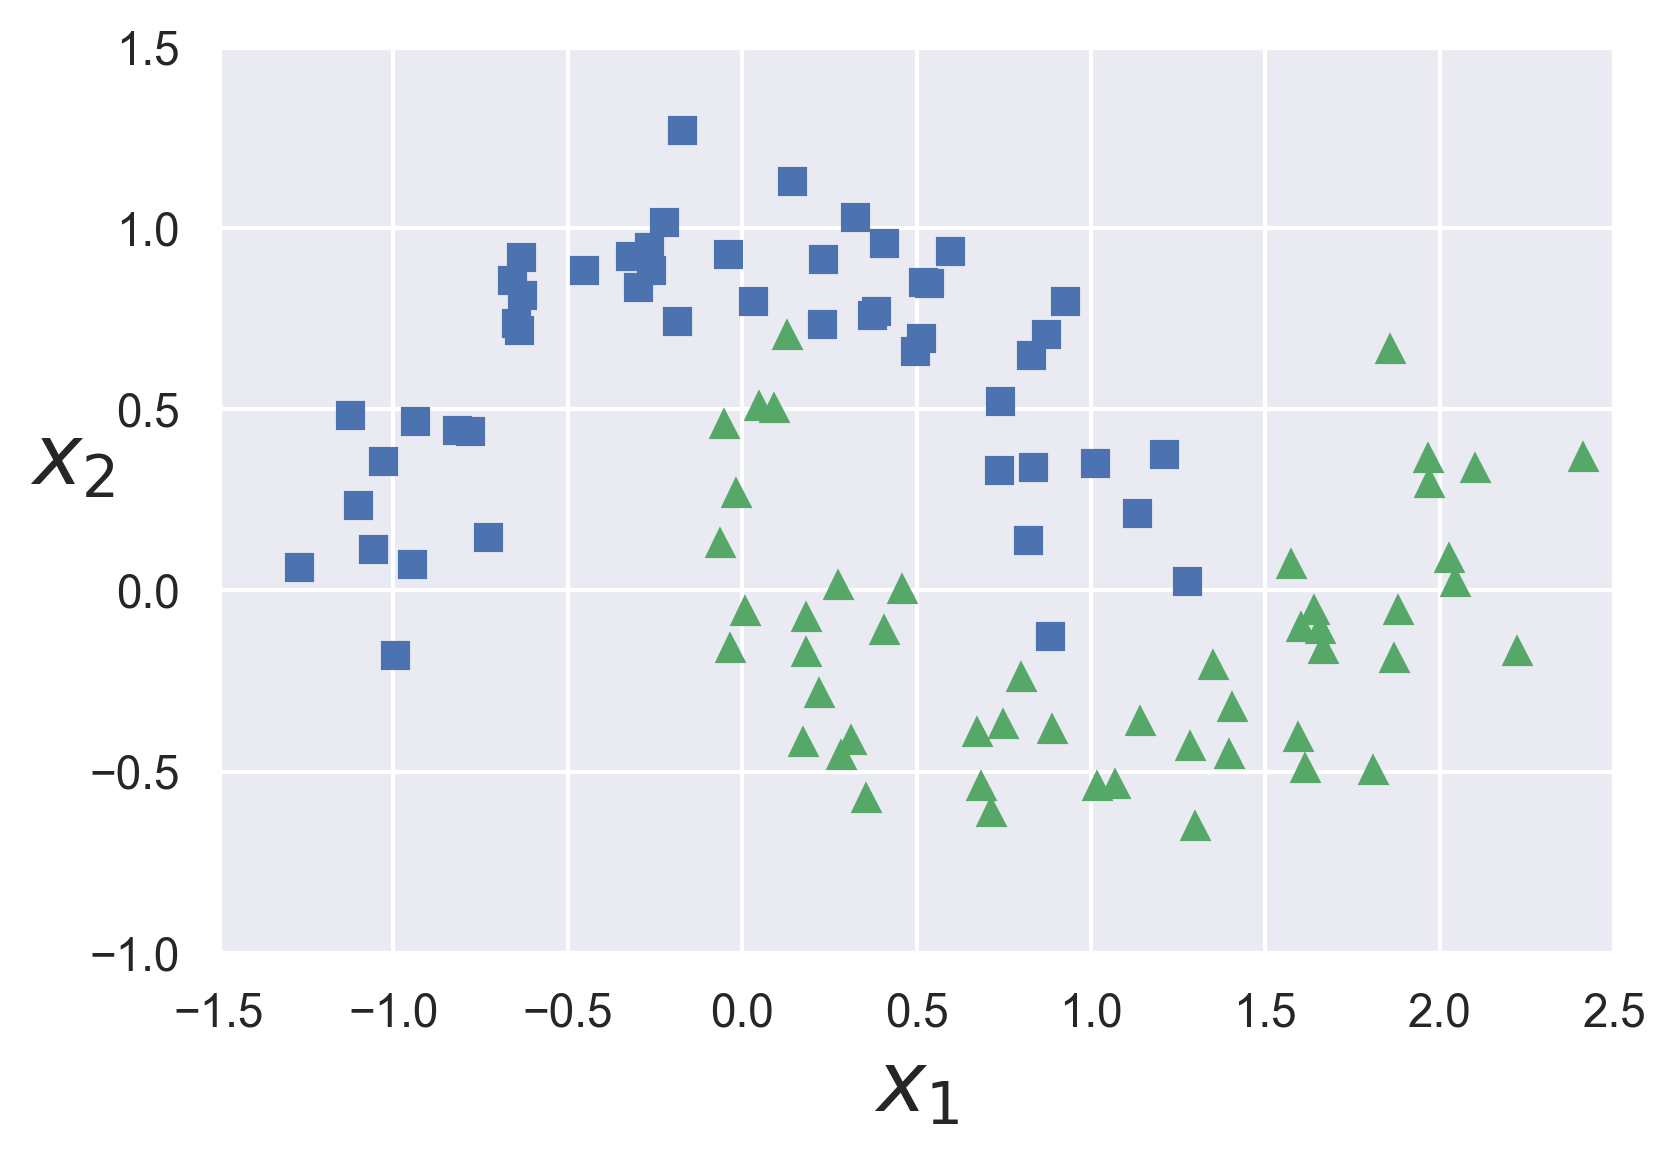

In [9]:
# https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [10]:
# https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_feat = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel='poly', degree=3, C=10, random_state=42))
    ])

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(color.BOLD+color.UNDERLINE+"Polynomial Feature Engineering"+color.END)
    %timeit polynomial_feat.fit(X, y)
    print(color.BOLD+color.UNDERLINE+"Polynomial Kernel"+color.END)
    %timeit polynomial_svm.fit(X, y)

Polynomial Feature Engineering
1.43 ms ± 4.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Polynomial Kernel
1.08 ms ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


...although in this case (with these specific hyperparameters) the feature engineering performs better. SVM can be sensitive to hyperparameter settings so we need to normally cross-validate these!

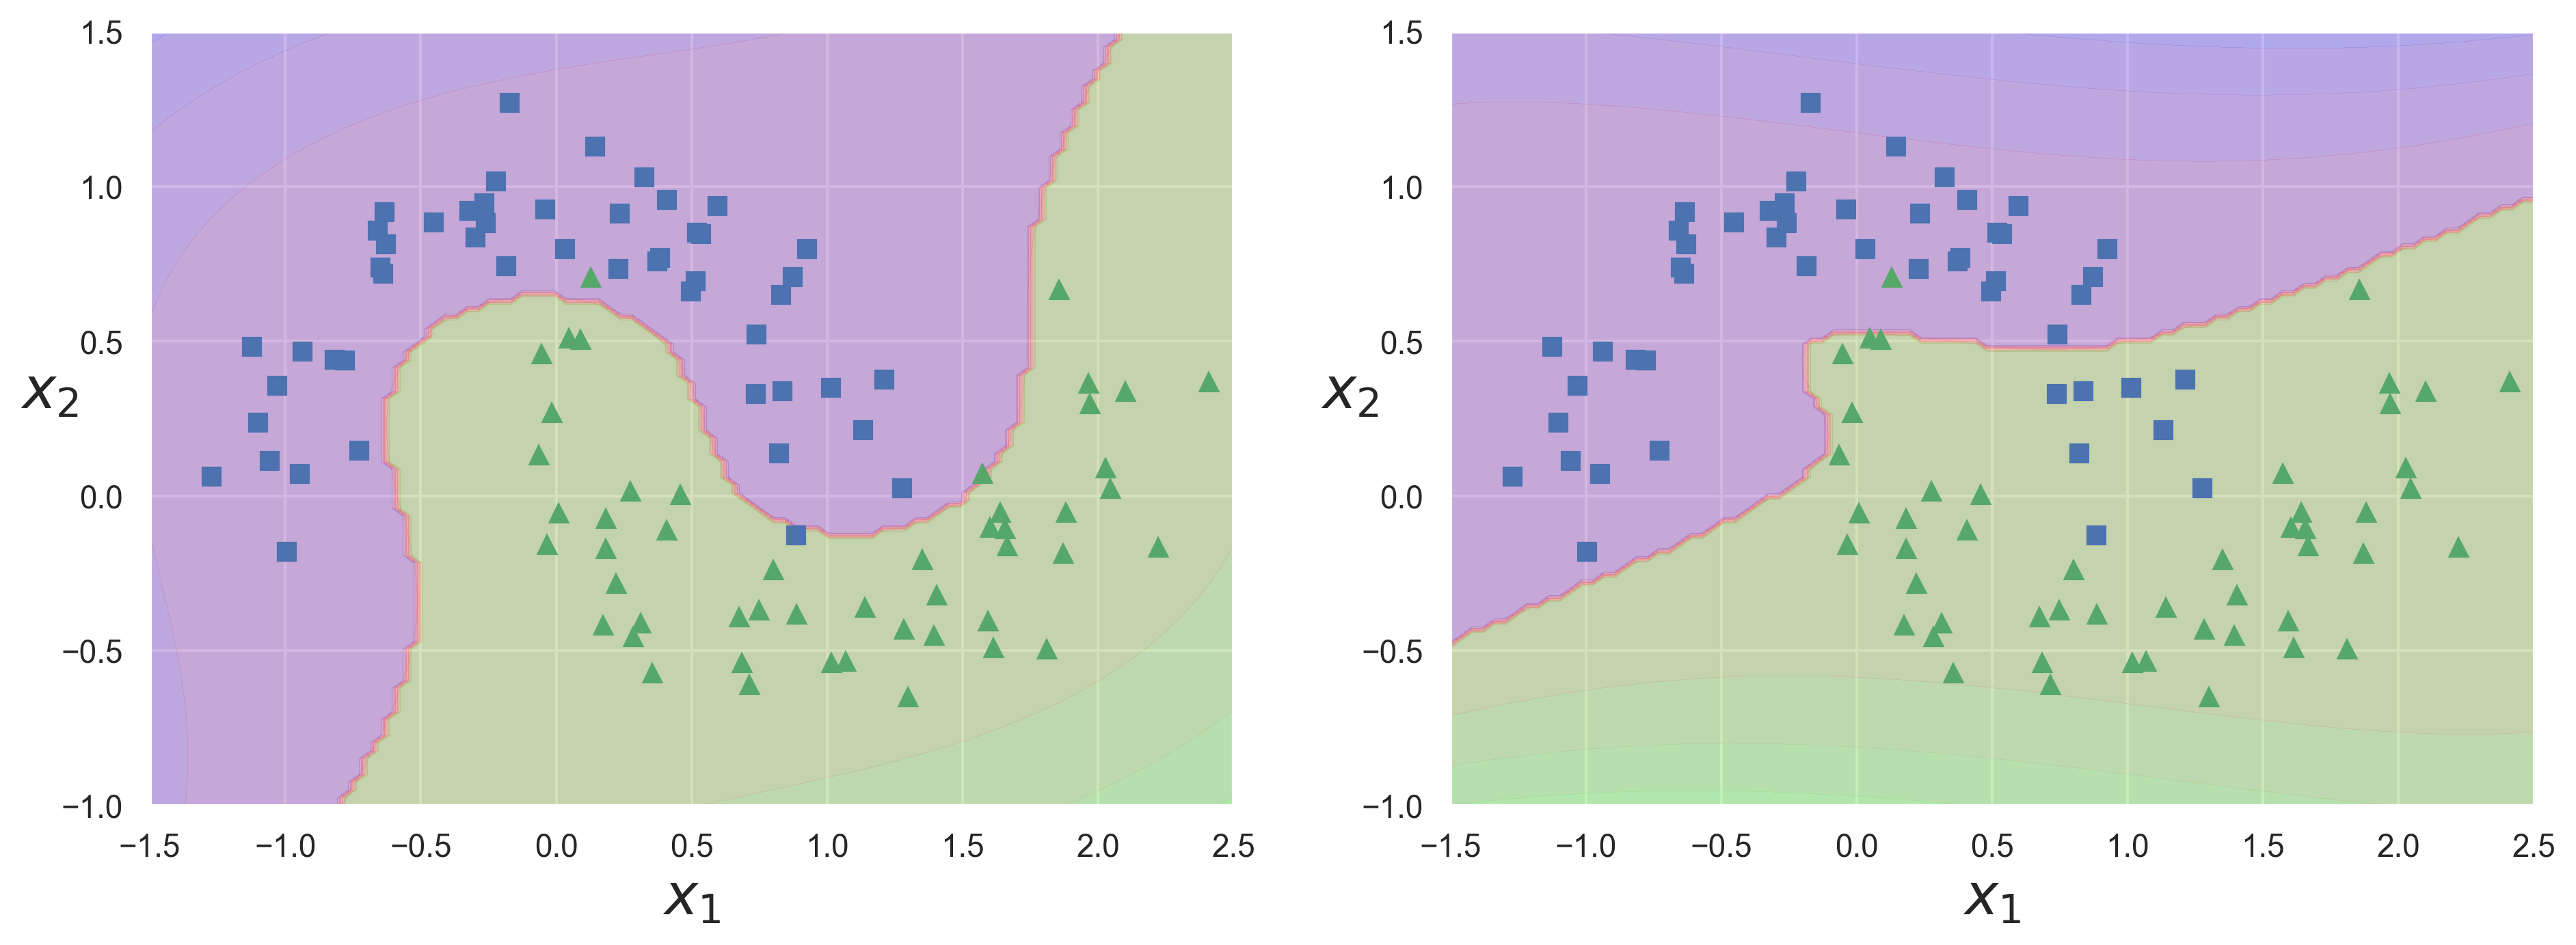

In [12]:
# https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plt.sca(axes[0])
plot_predictions(polynomial_feat, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.sca(axes[1])
plot_predictions(polynomial_svm, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

## Kernels

The Kernel trick can relies on the fact we can define our SVM in the form of dot products, $\mathbf{x}_i\cdot \mathbf{x}_j$.

Imagine we had a mapping $\Phi$ which maps the data to some high dimensional Euclidean space 

$\Phi: \mathbb{R}^d \mapsto H$,

then we would still be using dot products in $H$. However we could instead use a kernel function

$K(\mathbf{x}_i,\mathbf{x}_j) = \Phi(\mathbf{x}_i)\cdot \Phi(\mathbf{x}_j)$,

meaning we don't need to worry about $\Phi$; saving us computation. 

We still have all the same considerations, but replacing $\mathbf{x}_i\cdot \mathbf{x}_j$ with $K(\mathbf{x}_i, \mathbf{x}_j)$ allows us to produce a SVM in infinite dimensional space.

In the test phase, instead of test point computing the sign of $\mathbf{x}^*$ with $\mathbf{w}$, we can use the support vectors, $\mathbf{s}_i$:

$f(\mathbf{x}^*) = \sum_{i = 1}^{N_S}\alpha_iy_i\Phi(\mathbf{s}_i)\cdot \Phi(\mathbf{x}) +b = \sum_{i = 1}^{N_S}\alpha_iy_iK(\mathbf{s}_i,\mathbf{x}) +b$,

avoiding computing $\Phi(\mathbf{x}^*)$.

---
Burges, C. J. (1998). A tutorial on support vector machines for pattern recognition. Data mining and knowledge discovery, 2(2), 121-167.

__Notes__

- Roughly speaking, a kernel can be interpreted as a similaraity function betwen pairs of samples<sup>4</sup>.
- $\mathbf{w}$ lives in $H$ ("high dimensional")
- $H$ is often refered to as a Hilbert space.
- _"it is clear that the above implicit mapping trick will work for any algorithm in which the data only appear as dot products (for example, the nearest neighbor algorithm). This fact has been used to derive a nonlinear version of principal component analysis by (Scholkopf, Smola and Muller, 1998b); it seems likely that this trick will continue to find uses elsewhere."_ Burges, C. J. (1998). A tutorial on support vector machines for pattern recognition. Data mining and knowledge discovery, 2(2), 121-167.

## Polynomial kernels

[INSERT]

__Notes__

- argueably a polynomial is not a proper kernel (see REF)
- If you start to overfit you should reduce the polynomial degree and underfitting try increasing it.
- `coef0` roughly controls how much the model is influenced by high-degree polynomials<sup>2</sup>

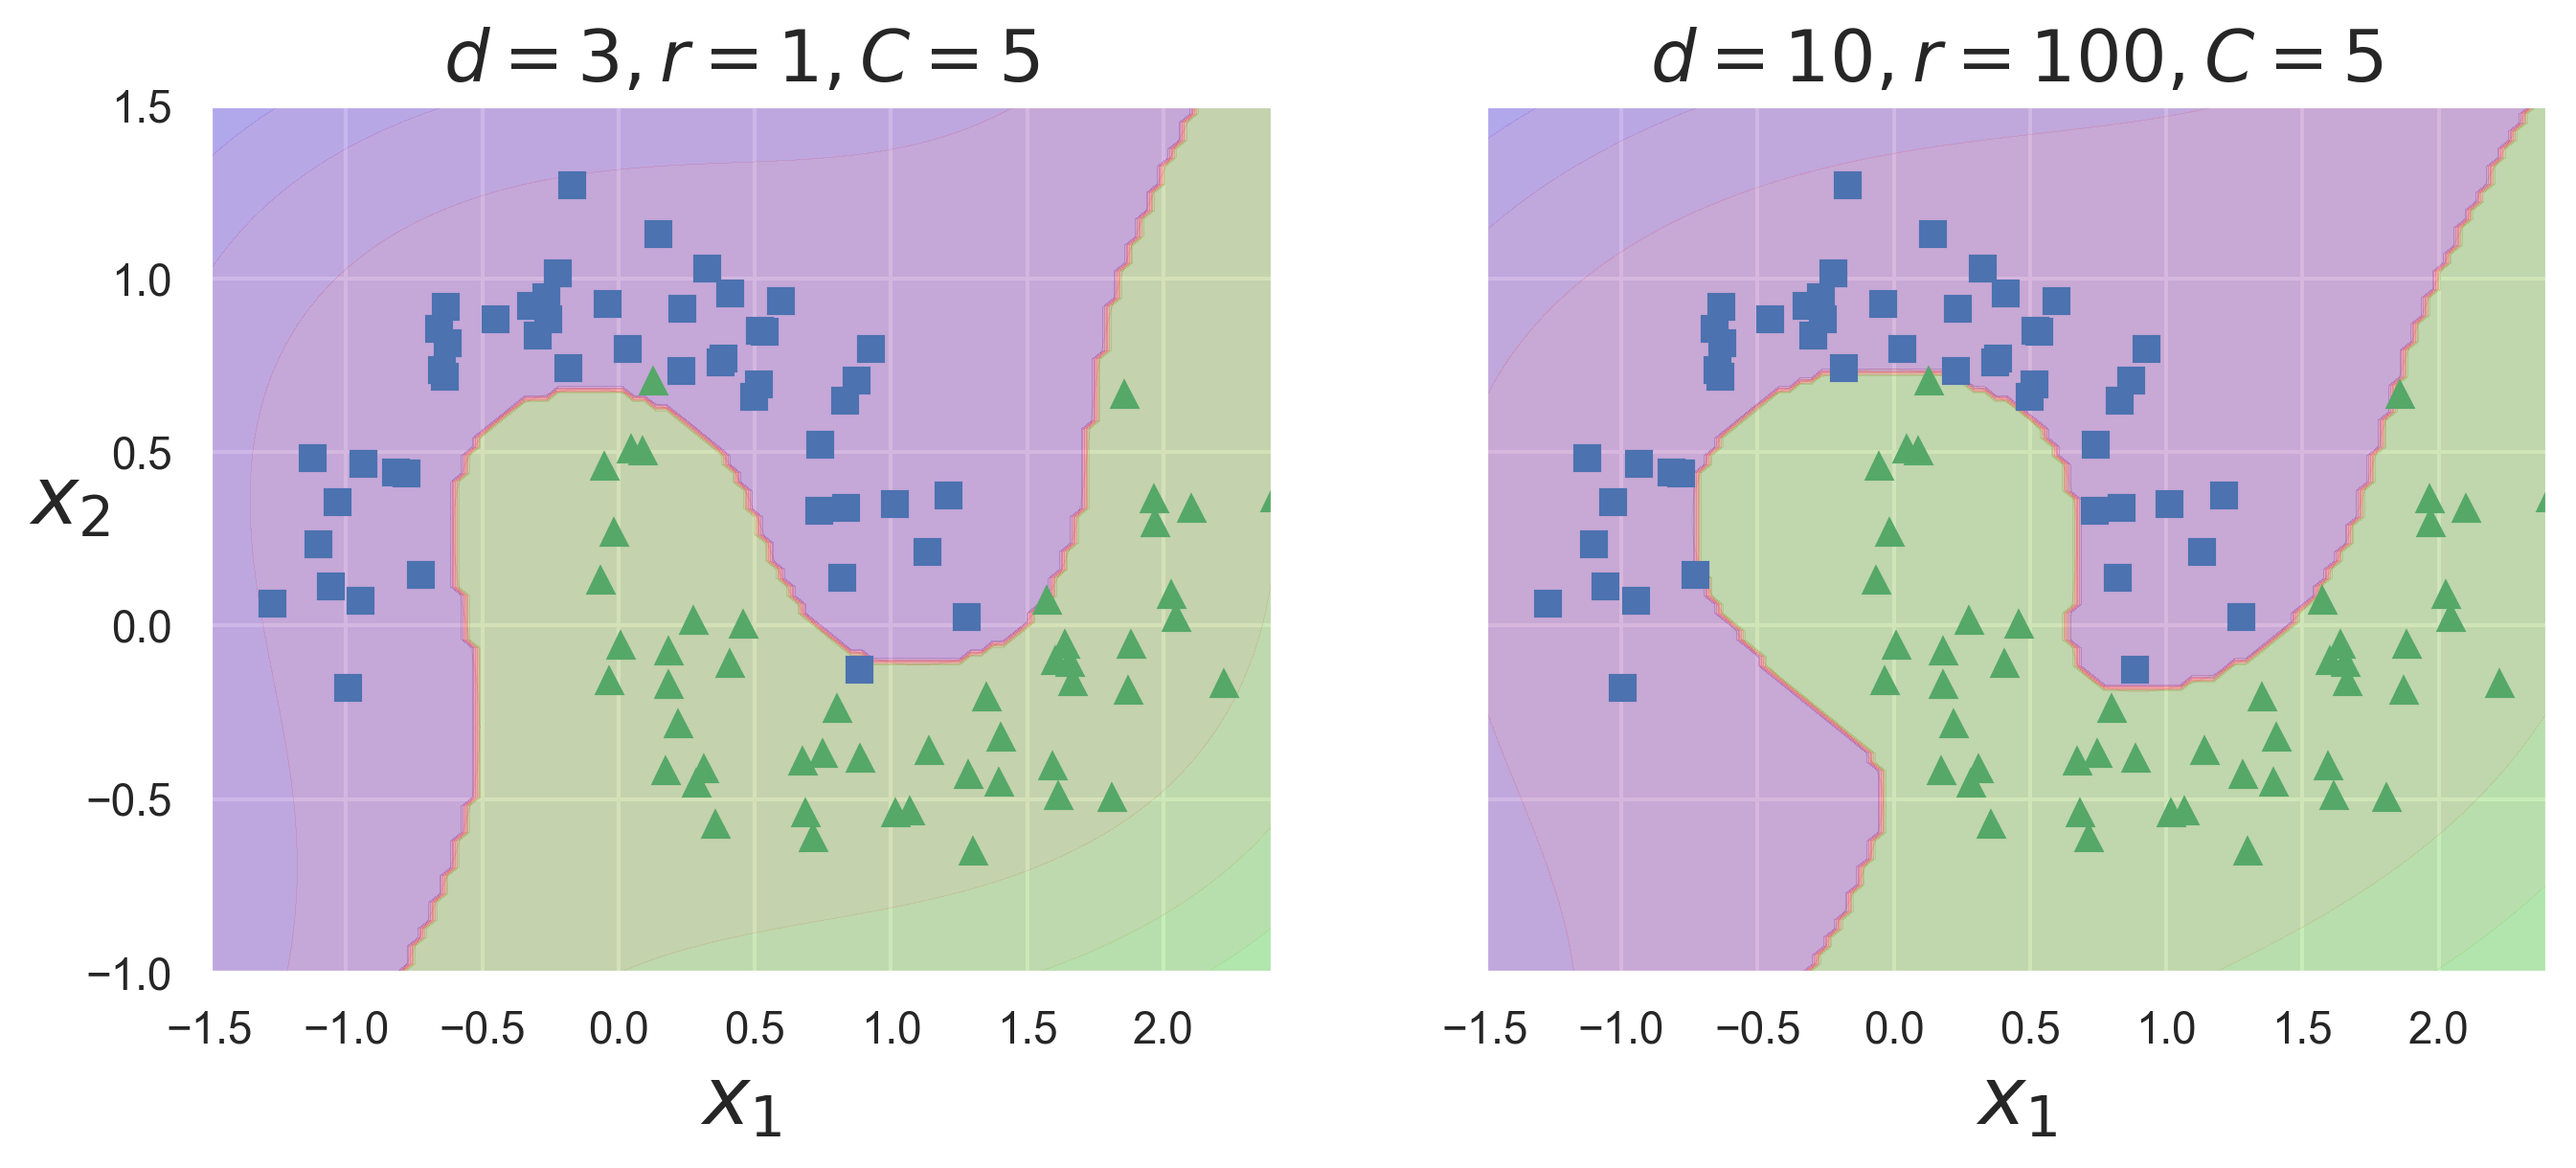

In [19]:
from sklearn.svm import SVC

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

## Radial kernel
[INSERT]

Another popular choice is the _radial kernel_:

$K(x_i, x_{i'}) = exp(-\gamma\sum^P_{j=1}(x_{ij}-x_{i'j})^2)$,

where $\gamma$ is a positive integer.

---
Burges (1998)

A Radial Basis Function (RBF) kernel or Gaussian kernel
    
$\kappa(\mathbf{x}_i,\mathbf{x}_j) = \exp\left(\frac{||\mathbf{x}_i,\mathbf{x}_j||^2}{2\sigma^2}\right)$

or simply

$\kappa(\mathbf{x}_i,\mathbf{x}_j) = \exp\left(-\gamma||\mathbf{x}_i,\mathbf{x}_j||^2\right)$

$\gamma = \frac{1}{2\sigma^2}$

where $\gamma$ is a free parameter to be optimised.

---
python machine learning

When using a SVM model trained using a RBF kernel classifies a test observation $x^* = (x^*_1...x^*_p)$, only training observaations close to $x^*$ (in terms of Euclidean distance) will play a role in its class label. This is because $(x^*_j-x_{ij})^2$ will be large, so $exp(-\gamma\sum^P_{j=1}(x^*_j-x_{ij})^2)$ will be small.

__[MORE INFO ON RBF kernels]__

__[MORE INFO ON HOW C AND GAMMA INTERACT]__

__TODO__
- Include notes from "choosing c" on pg. 506 from ML a probabilistic perspective.

Increasing gamma ($\gamma$) makes the bell-shaped curve narrower (so each instances range of influence is smaller) - having the effect that the boundary becomes more irregular. Small $\gamma$ makes the bell-shaped curve wider - instances have a larger range of influence and therefore a smoother decision boundary<sup>2</sup>.

$\gamma$ is effectively acting like a regularization hyperparameter, so like $C$ if your model is overfitting reduce it and underfitting then increase it.

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


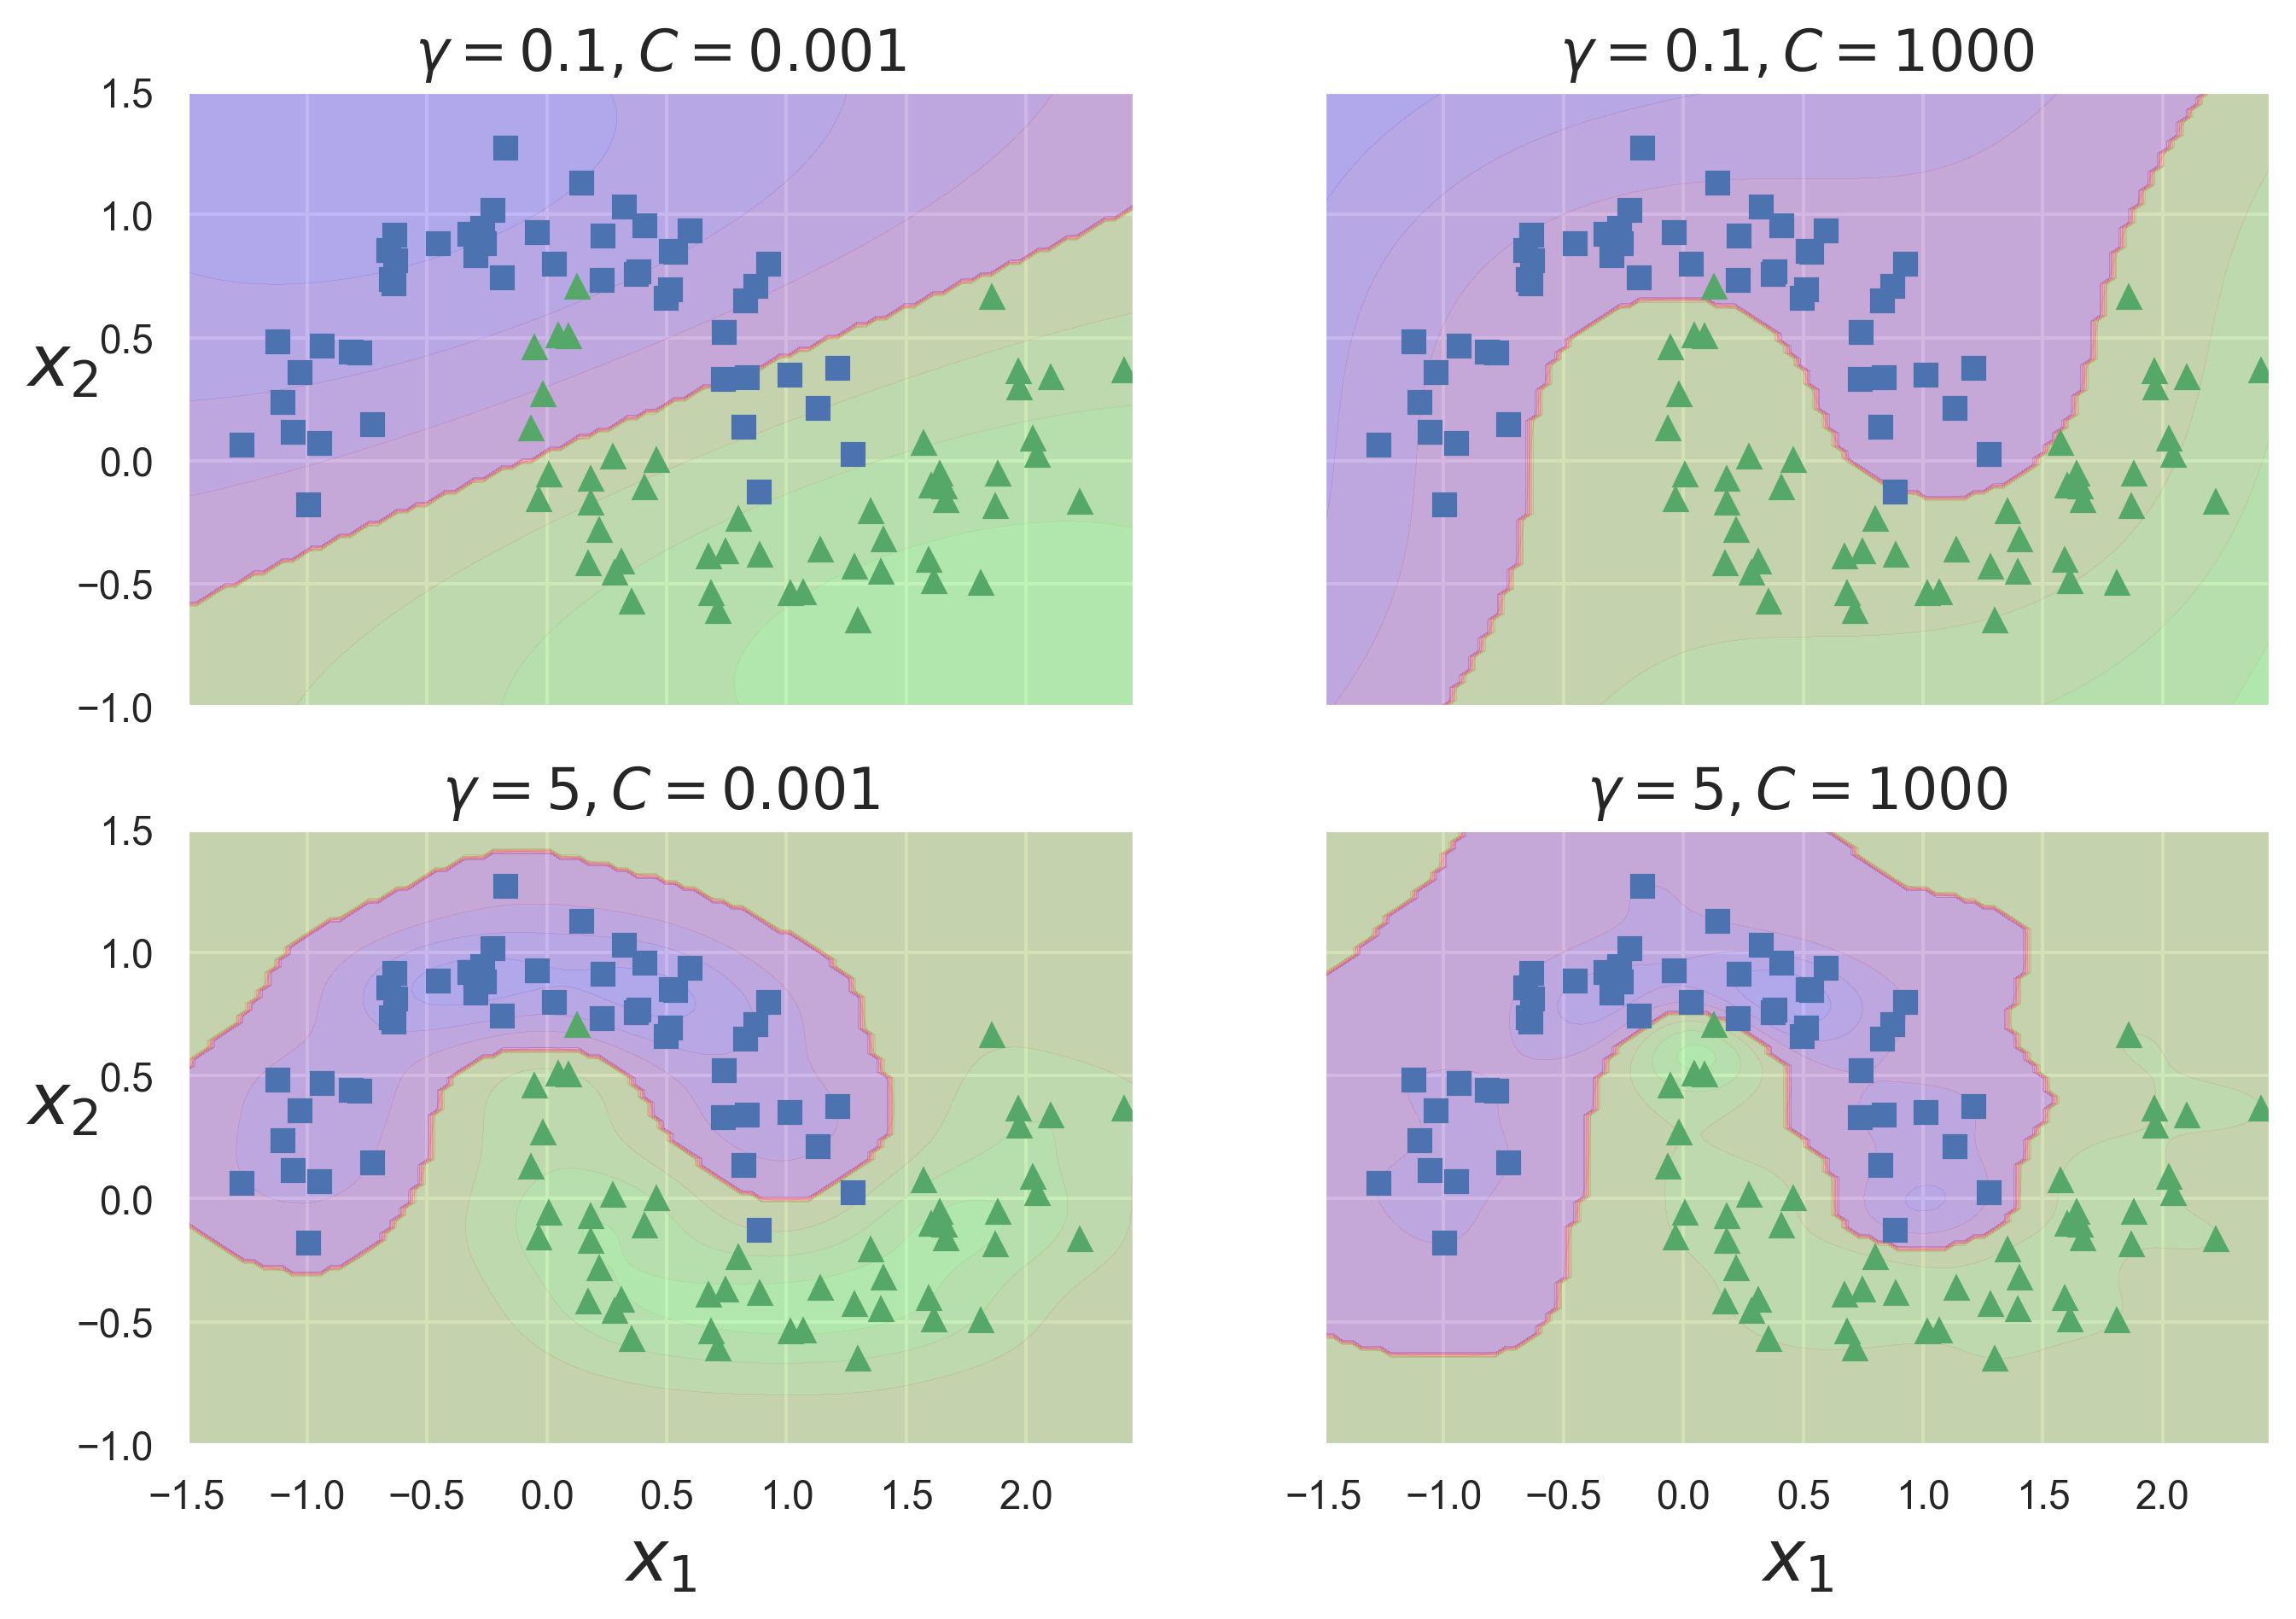

In [20]:
gamma = 0.3
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]


x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))
    
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

Other kernels exist, but less commonly used. It depends on the data structure

__[create table with examples starting with Sring kernels for text documents or DNA sequences]__

see pg. 161 of hands on ML

## Advantages

_"It is this fact that allows us to construct hyperplanes in these very high dimensional spaces yet still be left with a tractable computation. Thus SVMs circumvent both forms of the “curse of dimensionality”: the proliferation of parameters causing intractable complexity, and the proliferation of parameters causing overfitting."_ Burges (1998)

## Disadvantages

_"Perhaps the biggest limitation of the support vector approach lies in choice of the kernel. Once the kernel is fixed, SVM classifiers have only one user-chosen parameter (the error penalty), but the kernel is a very big rug under which to sweep parameters. Some work has been done on limiting kernels using prior knowledge (Scholkopf et al., 1998a; Burges, 1998), but the best choice of kernel for a given problem is still a research issue."_ Burges (1998)

_"A second limitation is speed and size, both in training and testing. While the speed problem in test phase is largely solved in (Burges, 1996), this still requires two training passes. Training for very large datasets (millions of support vectors) is an unsolved problem"_ Burges (1998)

_"Discrete data presents another problem, although with suitable rescaling excellent results
have nevertheless been obtained (Joachims, 1997)."_ Burges (1998)

__Recap using different formulation__

The kernel apporach is an efficient computational approach to enlarge our feature space to accommodate a non-linear boundary.

Skipping over some technical details, it turns out we can use the inner products of two observations rather than using the observations themselves:

$<x_i,x_{i^{\prime}}> = \sum^P_{j=1}x_{ij}x_{i^{\prime}j}$.

Using this we can represent the linear support vector classifier as: 

$f(x) = \beta_0 + \sum^n_{i=1}\alpha_i<x,x_i>$.

In the above case, for estimating the parameters $\alpha_1...,\alpha_n$ and $\beta_0$, we need the $n(n-1)/2$ inner products $<x,x_i>$ between all pairs of training observations. Similarly, if wanted to compute $f(x)$ we would need to the inner product between $x$ and each training point $x_i$.

However, $\alpha$ is nonzero only for support vectors, so if we have a collection of indicies of these support points we can do the following instead:

$f(x) = \beta_0 + \sum_{i\in S}\alpha_i<x,x_i>$.

Also instead of actually calculating the inner product, we could instead use a _generalisation_, $K(x,x_{i^{\prime}})$, where $K$ is a _kernel_. We can now define the classifier as:

$f(x) = \beta_0 + \sum_{i\in S}\alpha_iK(x,x_i)$.

A kernel is a function that quantifies the similarity of two observations. For example, for a _linear kernel_ we could use:

$K(x_i, x_{i'}) = \sum^P_{j=1}x_{ij}x_{i'j}$,

where we quantifiy the similarity of pairs of observations using Pearson (standard) correlation.

However, we could use other forms of kernel to fit the support vector classifier in a higher-dimensional space, such as a _polynomial kernel_:

$K(x_i, x_{i'}) = (1+\sum^P_{j=1}x_{ij}x_{i'j})^d$,

where d is a positive integer.

Another popular choice is the _radial kernel_:

$K(x_i, x_{i'}) = exp(-\gamma\sum^P_{j=1}(x_{ij}-x_{i'j})^2)$,

where $\gamma$ is a positive integer.

---
James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112, p. 18). New York: springer.

__Extra Example__

Lets have a look how our RBF does on our original example of non-linear data

In [15]:
def non_linear_examples():
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 5))
    axes = axes.flatten()
    plt.sca(axes[0])
    nl1, y1 = make_classification(n_samples=300, n_features=2, 
                                          n_redundant=0, n_informative= 2, 
                                          n_classes=3, n_clusters_per_class=1, 
                                          random_state=14, class_sep=30, 
                                          hypercube=False)
    y1 = np.where(y1==1,0,y1)
    y1 = np.where(y1==2,1,y1)
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)

    plt.sca(axes[1])
    nl2, y2 = make_moons(n_samples=300, noise=0.15, random_state=42)
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)
    
    svm_clf1 = SVC(random_state=42).fit(nl1, y1)
    svm_clf2 = SVC(random_state=42).fit(nl2, y2)

    plt.sca(axes[2])
    plot_predictions(svm_clf1, [-5, 5, -5, 7.5])
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)

    plt.sca(axes[3])
    plot_predictions(svm_clf2, [-1.5, 2.5, -1, 1.5])
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)
    plt.suptitle('Radial Basis Kernel')

    plt.show()
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    non_linear_examples()

# Associated Exercises

Now might be a good time to try exercises X-X.

# References
1. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112, p. 18). New York: springer.
2. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
3. Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. " O'Reilly Media, Inc.".
4. Raschka, 2016
5. Cortes, C. and Vapnik, V. Support vector networks. Machine Learning, 20:273–297, 1995
6. Burges, C. J. (1998). A tutorial on support vector machines for pattern recognition. Data mining and knowledge discovery, 2(2), 121-167.
7. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.

web1.  https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
web2. https://scikit-learn.org/stable/datasets/toy_dataset.html

In [21]:
!jupyter nbconvert 2_Support_Vector_Machines.ipynb \
    --to slides \
    --output-dir . \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True \
    --SlidesExporter.reveal_scroll=True

[NbConvertApp] Converting notebook 2_Support_Vector_Machines.ipynb to slides
[NbConvertApp] Writing 4659256 bytes to 2_Support_Vector_Machines.slides.html
